## Outline of Main Parts

#### 1. Data Downloader 
    - Build the Database.  Builds separate databases for FY and FQ data.
#### 2. Backtest - Filtering
    - Queries the MongoDB database to get a list of healthy companies and their relevant period
#### 3. Backtest - Pricing 
    - Takes the list of healthy companies and gets prices for the company at the start of the period 
    and in subsequent periods to measure growth.
    
#### 4. Machine Learning - Constructing the Models and Training them on Additional Features
    - For the healthy companies, download additional features (financial metrics) and train a neural network to classify
    high performing healthy companies and low performing healthy companies.

#### 5. Database Updater 
    - Update the database daily/frequently.  Adds new companies and new financial periods to existing companies.
#### 6. Stock Screener 
    - Scans the database for companies that are healthy in the most recent period.
    - Run every time the database is updated to determine if any healthy companies/periods have been added.
    
#### 7. ML Models' Classifications of Screened Companies
    - Takes the results from the screener (Part 6) and inputs them into the models, which outputs classification predictions

### Header and Import Packages

In [1]:
# Import Packages
import requests, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import timeit
import joblib
import pickle
import statistics
from statistics import mean
import seaborn as sns

from pymongo import MongoClient,InsertOne, DeleteOne, ReplaceOne, UpdateOne

from datetime import datetime, timedelta
from tqdm import tqdm
from tpot import TPOTClassifier
import yfinance as yf
import autokeras as ak
 
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import models, layers, backend, regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report

C:\Users\cdpsu\anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [2]:
# QuickFS API Key
# 25,000 calls per day
api_key = "xxxxxxxxxxxxxxxxxxxxxxxxx"

header = {'x-qfs-api-key': api_key}

# Alpha Vantage API Key. 5 Calls per minute
alpha_api_key = "xxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

# FMP API Key
fmp_api_key = "xxxxxxxxxxxxxxxxxxxxxxx"

### Helper Functions

In [3]:
##############################################################################################################################
###################################### General Quick FS Helper Functions #####################################################
##############################################################################################################################

# Check API Usage
def datapoints_remaining(header):
    try:
        # Make the request from the API
        s = requests.get('https://public-api.quickfs.net/v1/usage',headers=header)
        x = s.json()
        # Parse the return dictionary for the value of API calls remaining
        remaining = x['usage']['quota']['remaining']
    except:
        remaining = 0
    return remaining

# Get List of Supported Companies 
# Country Codes: US, CA, AU, NZ, MM, LN, ALL
def get_supported_companies(header, code):
    codes_list = ("US","CA",'AU','NZ','MM','LN','ALL')
    # Error Handle
    if code not in codes_list:
        cos = []   
    # If I want to get all companies
    if code == "ALL":
        try:
            r = requests.get('https://public-api.quickfs.net/v1/companies',headers=header)
            x = r.json()
            cos = x['data']
        except:
            cos = []
    # If I want a specific country's companies
    else:
        try:
            r = requests.get('https://public-api.quickfs.net/v1/companies/'+code,headers=header)
            x = r.json()
            cos = x['data']
        except:
            cos = []
    return cos
 
# Downloading one feature
def feature_download(feature,header,co,period):
    if period == "FY":
        timeframe = "FY-19:FY"
    else:
        timeframe = "FQ-79:FQ"
    
    request_body = {
    "data" : {
        co: {
            feature : "QFS("+co+","+feature+","+timeframe+")",      
             }
        }
    }

    r = requests.post("https://public-api.quickfs.net/v1/data/batch",json=request_body,headers=header)
    my_data = r.json()        
    return my_data['data'][co][feature]

##############################################################################################################################
####################### Custom Feature Engineering, Datacleaning, and Backtesting functions  #################################
##############################################################################################################################

# Calculate growth rates based on values, for income statement and CF statement features
# These features aggregate over the four quarters and are compared to the previous four quarters
def over_time_growth_rates(values_list):
    '''
    Need to calculate a growth rate every period
    '''
    # Initiate placeholder list
    growth_rates = []

    # Iterate through list of value_list in reverse
    for x in range(len(values_list)-1,0-1,-1):

        # check if there's enough prior periods to calculate growth rate
        if x-7 >= 0:
            # Calculate growth rate
            end = sum(values_list[x-3:x+1])
            beginning = sum(values_list[x-7:x-3])

            # Rate calculation
            if beginning == 0:
                rate = 0
            else:
                rate = (end - beginning) / beginning

            #QFS handles growing from a negative to a postive (or slightly less negative) in this way
            if beginning < 0:
                rate = abs(rate)  

        # If not enough prior periods to calculate rate, put a NaN
        else:
            rate = float("NaN")
        growth_rates.append(rate)

    return list(reversed(growth_rates))

# Given a list of period data for a financial metric, find the 
# 10 year, 7 year, 5 year, 3 year, 1 year averages
def avg_list(list1, period):
    list2 = []
    
    # First toggle quarterly or annually
    if period == "FQ":
        growth_rates = []
        # if the company even has enough data (10 years), calculate the mean
        if np.count_nonzero(~np.isnan(list1[-40:])) >= 40:
            # Iterate through the list in reverse
            for x in range(len(list1)-1,0-1,-1):
                # add the growth rate of every fourth quarter to a list
                if (x + 1) % 4 == 0:
                    growth_rates.append(list1[x])
            
            # Reverse the list so it is in the correct order
            growth_rates = list(reversed(growth_rates))
            
            # Calculate growth rates
            list2.append(mean(growth_rates[-10:]))
            list2.append(mean(growth_rates[-7:]))
            list2.append(mean(growth_rates[-5:]))
            list2.append(mean(growth_rates[-3:]))
            list2.append(mean(growth_rates[-1:]))
        else:
            list2.append(float('NaN'))
            list2.append(float('NaN'))                    
            list2.append(float('NaN'))
            list2.append(float('NaN'))
            list2.append(float('NaN'))
            
    else:    
        # if the company even has enough data (10 years), calculate the mean
        if np.count_nonzero(~np.isnan(list1[-10:])) >= 10:
            list2.append(mean(list1[-10:]))
            list2.append(mean(list1[-7:]))
            list2.append(mean(list1[-5:]))
            list2.append(mean(list1[-3:]))
            list2.append(mean(list1[-1:]))
        # Otherwise, append NaNs
        else:
            list2.append(float('NaN'))
            list2.append(float('NaN'))                    
            list2.append(float('NaN'))
            list2.append(float('NaN'))
            list2.append(float('NaN'))
    
    return list2

# Check if all values in a list are greater than a certain value
def check(list1, val):
    return(all(x >= val for x in list1))

##############################################################################################################################
######################################### Pricing Data Downloading ###########################################################
##############################################################################################################################

# For Alphavantage and Financial Modeling Prep
# API Downloader
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
    
def get_jsonparsed_data(url):
    counter = 0
    while True:
        if counter > 3:
            break
        try:
            response = urlopen(url)
            data = response.read().decode("utf-8")
            return json.loads(data)
        except :
            time.sleep(5)
            counter += 1
        else :
            #stops the inner loop if there is no error
            break
            
# Yahoo Finance Price Getter
def get_yahoo_price(ticker, date):
    # If date is in the future, return blank
    if date > datetime.today():
        return float("NaN")
    # Download Data
    data_df = yf.download(ticker, start=date, end=date + timedelta(days=1),progress=False)
    try:
        # Get price point
        return data_df['Adj Close'][0]
    except:
        return float("NaN")
    
##############################################################################################################################
############################################# MongoDB Functions ##############################################################
##############################################################################################################################    

# Get Lis of Cos already in database
def get_existing_cos(database,collection):
    # Go through database and save the ticker into a list
    existing_cos = []
    #MongoDb connection
    client = MongoClient()
    db = client[database]
    collections = db[collection]
    # Blank Query finds all
    query = { }
    selection = collections.find(query)
    for doc in selection:
        existing_cos.append(doc['ticker'])
    return existing_cos

'''
####################################################################################################################3
Batch Download Function - Gets data from QFS
####################################################################################################################
'''
# period = "FY" or "FQ" for fiscal year or fiscal quarter.
def batch_download(header,co,period):
    
    # Handle Different Periods
    if period == "FY":
        timeframe = "FY-19:FY"
        multiplier = 1
    elif period == "FQ":
        timeframe = "FQ-79:FQ"
        multiplier = 4
    else:
        print("Period not supported")
        exit()
    
    # API Request
    request_body = {
    "data" : {
        co: {
            "original_filing_date" : "QFS("+co+",original_filing_date,"+timeframe+")",
            "roic" : "QFS("+co+",roic,"+timeframe+")",      
            "total_equity_growth" : "QFS("+co+",total_equity_growth,"+timeframe+")",
            "eps_diluted_growth" : "QFS("+co+",eps_diluted_growth,"+timeframe+")",
            "revenue_growth" : "QFS("+co+",revenue_growth,"+timeframe+")",
            "revenue" : "QFS("+co+",revenue,"+timeframe+")",
            "fcf" : "QFS("+co+",fcf,"+timeframe+")",
            "lt_debt" : "QFS("+co+",lt_debt,"+timeframe+")",
            "fcf_growth" : "QFS("+co+",fcf_growth,"+timeframe+")",
             }
        }
    }

    r = requests.post("https://public-api.quickfs.net/v1/data/batch",json=request_body,headers=header)
    my_data = r.json()

    #################################### Data Cleaning #########################################
    
    # Create empty lists for all the features
    original_filing_date = []
    roic = []
    total_equity_growth = []
    eps_diluted_growth = []
    revenue_growth = []
    revenue = []
    fcf = []
    fcf_growth = []
    lt_debt = []
    payback_time = []
    
    # FCF is an unsupported metric for some companies and QFS returns one value 'UnsupportedMetricError'
    # Replace this one value with x amount of NaNs 
    
    #Create placeholder lists
    fcfs = []
    fcfs_growth = []
    # If unsupported, make as many NaNs values as in the date feature for length consistency
    if 'Un' in str(my_data['data'][co]['fcf'][0]):
        for x in range(len(my_data['data'][co]['original_filing_date'])): 
            fcfs.append(float("NaN"))
            fcfs_growth.append(float("NaN"))      
    # Otherwise, data is valid, and keep that.
    else:
        fcfs = my_data['data'][co]['fcf']
        fcfs_growth = my_data['data'][co]['fcf_growth']
    
    
    # Replacing 0s with NaNs for years that the company didn't exist
    
    for x in range(len(my_data['data'][co]['original_filing_date'])):    
        # if the prefix '20' - meaning a valid year, ex: 2020 - isn't in the data for filing_date, then replace that datapoint 
        # in all the features with NaN. 
        if '20' not in str(my_data['data'][co]['original_filing_date'][x]):
            original_filing_date.append(float("NaN"))
            roic.append(float("NaN"))
            total_equity_growth.append(float("NaN"))
            eps_diluted_growth.append(float("NaN"))
            revenue_growth.append(float("NaN"))
            revenue.append(float("NaN"))
            fcf.append(float("NaN"))
            fcf_growth.append(float("NaN"))
            lt_debt.append(float("NaN"))
        # Otherwise, put the valid values for all features into the corresponding lists
        else:
            original_filing_date.append(my_data['data'][co]['original_filing_date'][x])
            roic.append(my_data['data'][co]['roic'][x])
            total_equity_growth.append(my_data['data'][co]['total_equity_growth'][x])
            eps_diluted_growth.append(my_data['data'][co]['eps_diluted_growth'][x])
            revenue_growth.append(my_data['data'][co]['revenue_growth'][x])
            revenue.append(my_data['data'][co]['revenue'][x])
            fcf.append(fcfs[x])
            fcf_growth.append(fcfs_growth[x]) 
            lt_debt.append(my_data['data'][co]['lt_debt'][x])
    #####################################################################################################   

    #################### Feature Engineering ################

    #Payback time (How long LT_Debt takes to be paid off using FCF)
    # Loop through lt_debt feature
    for x in range(len(lt_debt)):
        # Calculate debt ratio if possible
        try:
            payback_time.append(lt_debt[x] / fcf[x])
        # Otherwise, if divide by 0 error (or any other error), payback_time = NaN
        except:
            payback_time.append(float("NaN"))

    # revenue_growth and fcf growth
    # Revenue and FCF accrue over time.  Calculating annual growth rate on quarterly values requires
    # a custom function
    if period == "FQ":
        revenue_growth = over_time_growth_rates(revenue)
        fcf_growth = over_time_growth_rates(fcf)

    #######################################################################################################       

    # Create a dictionary of the resulting, cleaned, featured engineered data
    # This will be all the data for the company and putting into a dict will make it easy to store
    my_dict = {}

    # Adhoc Feature Engineering - Metadata
    my_dict['ticker'] = co
    my_dict['update_time'] = datetime.now()
    my_dict['periods'] = np.count_nonzero(~np.isnan(roic))

    # Cleaned Features
    my_dict['original_filing_date'] = original_filing_date
    my_dict['roic'] = roic
    my_dict['total_equity_growth'] = total_equity_growth
    my_dict['eps_diluted_growth'] = eps_diluted_growth
    my_dict['lt_debt'] = lt_debt
    my_dict['payback_time'] = payback_time
    my_dict['revenue_growth'] = revenue_growth
    my_dict['revenue'] = revenue
    my_dict['fcf_growth'] = fcf_growth
    my_dict['fcf'] = fcf

    ################################ More Feature Engineering #######################################

    # Averages to be tested against a threshold later.  
    #Faster to do it now than when querying the database

    # Balance sheet items: the value for the period in question represents the prior year. It is a snapshot in time
    my_dict['roic_averages'] = avg_list(roic, period)
    my_dict['total_equity_growth_averages'] = avg_list(total_equity_growth, period)
    my_dict['eps_diluted_growth_averages'] = avg_list(eps_diluted_growth, period)


    # However, Income statement and Cash flow Statement items need to aggregate over the year and be compared to the prior
    # year's aggregate.  For quarterly periods, this needs to be handled differently.
    my_dict['revenue_growth_averages'] = avg_list(revenue_growth, period)
    my_dict['fcf_growth_averages'] = avg_list(fcf_growth, period)
    #################################################################################################################

    return my_dict

'''
####################################################################################################################3
Machine Learning Helper Functions
####################################################################################################################
'''

def ML_data_downloader(header, co, period, healthy_filing_date, metric_list,return_list):
    
    # handle period
    if period == "FY":
        timeframe = "FY-19:FY"
        periods = 10
    else:
        timeframe = "FQ-79:FQ"
        periods = 40
    
    # Create API request
    request_body = {
        "data" : {
            co: {
                "original_filing_date" : "QFS("+co+",original_filing_date,"+timeframe+")",
                "market_cap" : "QFS("+co+",market_cap,"+timeframe+")",
                "period_end_price" : "QFS("+co+",period_end_price,"+timeframe+")",
                "price_to_earnings" : "QFS("+co+",price_to_earnings,"+timeframe+")",
                "price_to_book" : "QFS("+co+",price_to_book,"+timeframe+")",
                "price_to_sales" : "QFS("+co+",price_to_sales,"+timeframe+")",
                "price_to_fcf" : "QFS("+co+",price_to_fcf,"+timeframe+")",
                "enterprise_value_to_earnings" : "QFS("+co+",enterprise_value_to_earnings,"+timeframe+")",
                "enterprise_value_to_book" : "QFS("+co+",enterprise_value_to_book,"+timeframe+")",
                "enterprise_value_to_sales" : "QFS("+co+",enterprise_value_to_sales,"+timeframe+")",
                "enterprise_value_to_fcf" : "QFS("+co+",enterprise_value_to_fcf,"+timeframe+")",
                "gross_margin" : "QFS("+co+",gross_margin,"+timeframe+")",
                "ebitda_margin" : "QFS("+co+",ebitda_margin,"+timeframe+")",
                "operating_margin" : "QFS("+co+",operating_margin,"+timeframe+")",
                "pretax_margin" : "QFS("+co+",pretax_margin,"+timeframe+")",
                "net_income_margin" : "QFS("+co+",net_income_margin,"+timeframe+")",
                "debt_to_equity" : "QFS("+co+",debt_to_equity,"+timeframe+")",
                "debt_to_assets" : "QFS("+co+",debt_to_assets,"+timeframe+")",
                "equity_to_assets" : "QFS("+co+",equity_to_assets,"+timeframe+")",
                "assets_to_equity" : "QFS("+co+",assets_to_equity,"+timeframe+")",
                "eps_diluted_growth" : "QFS("+co+",eps_diluted_growth,"+timeframe+")",
                "shares_diluted_growth" : "QFS("+co+",shares_diluted_growth,"+timeframe+")",
                "cash_and_equiv_growth" : "QFS("+co+",cash_and_equiv_growth,"+timeframe+")",
                "ppe_growth" : "QFS("+co+",ppe_growth,"+timeframe+")",
                "total_assets_growth" : "QFS("+co+",total_assets_growth,"+timeframe+")",
                "total_equity_growth" : "QFS("+co+",total_equity_growth,"+timeframe+")",
                "roe" : "QFS("+co+",roe,"+timeframe+")",
                "roa" : "QFS("+co+",roa,"+timeframe+")",
                "roic" : "QFS("+co+",roic,"+timeframe+")",
                "roce" : "QFS("+co+",roce,"+timeframe+")",
                 }
            }
        }

    # Send request and parse the response
    r = requests.post("https://public-api.quickfs.net/v1/data/batch",json=request_body,headers=header)
    my_data = r.json()
    
    for x in range(len(my_data['data'][co]['original_filing_date'])):
        if healthy_filing_date == my_data['data'][co]['original_filing_date'][x]:
            position = x
    
    # Put response data from API call, as well as some metadata, into a dictionary and return it
    my_dict = {}
    
    my_dict['co'] = co
    my_dict['healthy_date'] = healthy_filing_date
    my_dict['period'] = period
    my_dict['returns'] = return_list
    
    for metric in metric_list:
        try:
            my_dict[metric] = my_data['data'][co][metric][position-periods + 1:position+1]
        except:
            my_dict[metric] = [float("NaN")] * periods
    
    return my_dict


# Compare % returns by the model vs passive returns, investing in all healthy companies
def strategy_returns(model, x_test, test_returns):
    # Make predictions
    y_pred = model.predict(x_test)

    y_pred_list = []

    # Convert probabilities to binary prediction
    for item in y_pred:
        if item > .50:
            y_pred_list.append(1)
        else:
            y_pred_list.append(0)

    # For companies that the model predicts as healthy, add the % return to a list and average
    investments = []
    for x in range(len(test_returns)):
        if list(y_pred_list)[x] == 1:
            investments.append(list(test_returns)[x])
    
    return (statistics.mean(investments),statistics.mean(test_returns),y_pred,y_pred_list)


## 1. Data Downloader

In [4]:
'''
Workings of the code:

Download Data from QFS and store it in MongoDB.  This can be run periodically to see if any new companies have been added.
Updating existing companies' data occurs in Step 5.

'''

# create connection with database
client = MongoClient()
client_name = "MSDS_692_Project"
db = client[client_name]
codes = ['US','AU','CA','LN','MM','NZ']
periods = ['FY','FQ']

# Download for FY then FQ
for period in periods:
    cos_added = 0
    
    if period == "FY":
        collection_names = ['US_FY','Australia_FY', 'Canada_FY', 'London_FY', 'Mexico_FY', 'NewZealand_FY']
    elif period == "FQ":
        collection_names = ['US_FQ','Australia_FQ', 'Canada_FQ', 'London_FQ', 'Mexico_FQ', 'NewZealand_FQ']

    # Download data for each collection
    for x in range(len(collection_names)):
        print(collection_names[x])

        # Set collection and country code
        collection = db[collection_names[x]]
        code = codes[x]
        collection_name = collection_names[x]

        # Get List of Supported Companies
        supportedCos = get_supported_companies(header,code)
        # Get Lis of Cos already in database
        existingCos = get_existing_cos(client_name,collection_name)

        # Get companiess that are supported but not in the database
        newCos = (list(list(set(supportedCos)-set(existingCos)) + list(set(existingCos)-set(supportedCos))))

        # For all companies that need to be added
        for co in tqdm(newCos):
            # Check if enough API calls remain
            if datapoints_remaining(header) > 10:
                #Download Data
                my_dict = batch_download(header,co, period)

            else:
                print("No API Calls Remaining")
                print(cos_added,"Companies Added")
                break

            collection.insert_one(my_dict)
            cos_added += 1

        print(period,'done')
        print(cos_added,"Companies Added")

US_FY


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Australia_FY


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


Canada_FY


0it [00:00, ?it/s]


London_FY


100%|██████████| 42/42 [00:21<00:00,  1.96it/s]


Mexico_FY


0it [00:00, ?it/s]


NewZealand_FY


0it [00:00, ?it/s]


done
0 Companies Added
US_FQ


100%|██████████| 5/5 [00:02<00:00,  2.10it/s]


Australia_FQ


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


Canada_FQ


0it [00:00, ?it/s]


London_FQ


100%|██████████| 42/42 [00:29<00:00,  1.43it/s]


Mexico_FQ


0it [00:00, ?it/s]


NewZealand_FQ


0it [00:00, ?it/s]

done
0 Companies Added


## 2. Backtest - Filtering

In [5]:
'''
Go through the database and get list of companies that meet the healthy criteria, 
and the period for which the company qualifies.

'''
# create connection 
client = MongoClient()
client_name = "MSDS_692_Project"
db = client[client_name]
periods = ['FQ', 'FY']

# Do for FQ then FY
for period in periods:

    # Handle Periods
    if period == "FQ":
        collection_names = ['US_FQ','Australia_FQ', 'Canada_FQ', 'London_FQ', 'Mexico_FQ', 'NewZealand_FQ']
        periods_and_tickers = []
        query = {'periods': {"$gt":39}}
        number_of_periods = 40
        
    elif period == "FY":
        collection_names = ['US_FY','Australia_FY', 'Canada_FY', 'London_FY', 'Mexico_FY', 'NewZealand_FY']
        periods_and_tickers = []
        query = {'periods': {"$gt":9}}
        number_of_periods = 10

    # Filter company by collection
    for x in range(len(collection_names)):
        colist = []
        print(collection_names[x])

        collection = db[collection_names[x]]

        selection = collection.find(query)
        for doc in selection:
            colist.append(doc['ticker'])

        for co in tqdm(colist):

            query = {'ticker': { "$eq":co} }
            selection = collection.find(query)
            # For each company in the collection, query the relevant financial metrics
            for doc in selection:
                ticker = doc['ticker']
                periods = doc['periods']
                original_filing_date = doc["original_filing_date"]
                roic = doc['roic']
                total_equity_growth = doc['total_equity_growth']
                eps_diluted_growth = doc['eps_diluted_growth']
                revenue_growth = doc['revenue_growth']
                fcf_growth = doc['fcf_growth']
                payback_time = doc['payback_time']

            # Start at 0 plus periods.  Allows for enough data to accumulate 
            for x in range(len(roic)-periods+number_of_periods-1,len(roic)):
                val =.10
                #ROIC
                list_of_averages = avg_list(roic[x-number_of_periods+1:x+1],period)
                if check(list_of_averages, val):
                    #Equity
                    list_of_averages = avg_list(total_equity_growth[x-number_of_periods+1:x+1],period)
                    if check(list_of_averages, val):
                        #EPS
                        list_of_averages = avg_list(eps_diluted_growth[x-number_of_periods+1:x+1],period)
                        if check(list_of_averages, val):
                            #Sales
                            list_of_averages = avg_list(revenue_growth[x-number_of_periods+1:x+1],period)
                            if check(list_of_averages, val):
                                #FCF
                                list_of_averages = avg_list(fcf_growth[x-number_of_periods+1:x+1],period)
                                if check(list_of_averages, val):
                                    if payback_time[x] <= 3:
                                        pair = (ticker, original_filing_date[x],period)
                                        periods_and_tickers.append(pair)

    print(len(periods_and_tickers),"Healthy Companies Found")
    periods_and_tickers_df = pd.DataFrame()
    
    # Save to excel.  Turn Tuple into a DataFrame
    
    tickers_ = []
    dates_ = []
    periods_ = []
    
    for item in periods_and_tickers:
        tickers_.append(item[0])
        dates_.append(item[1])
        periods_.append(item[2])    
    
    periods_and_tickers_df['Ticker'] = tickers_
    periods_and_tickers_df['Healthy Date'] = dates_
    periods_and_tickers_df['Period'] = periods_
    
    periods_and_tickers_df.to_excel("Code Inputs and Outputs/ Healthy Company List "+datetime.today().strftime('%Y-%m-%d')+".xlsx")

US_FQ


100%|██████████| 10311/10311 [05:25<00:00, 31.63it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Australia_FQ
Canada_FQ
London_FQ
Mexico_FQ
NewZealand_FQ
229 Healthy Companies Found
US_FY


100%|██████████| 11906/11906 [04:38<00:00, 42.82it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Australia_FY
Canada_FY
London_FY
Mexico_FY
NewZealand_FY
365 Healthy Companies Found


## 3. Backtest - Pricing

Three Sources
- AlphaVantage
- FMP
- Yahoo Finance

##### Workings of the Code in this section:
- Put list of companies and the periods into a nested dictionary, where the companies are the key and the values are dictionaries.  In these nested dictionaries the key is the date and the value is initially set to NaN.  Each time a price is found from a pricing source, the value is updated from NaN to that value.
- I first loop through the dictionary using the AlphaVantage pricing.  I update the dictionary with every price it can download.  I then move on the loop through the dictionary and look to only replace NaN values, not the values I already found.  I use Financial Modeling Prep second, and then Yahoo Finance third.  
- At the end of this process I convert the nested dictionary into a DataFrame, where each companie and period pair has prices for the start date, a week out, a month out, 6 months out, a year out, 18 months out, and 2 years out. 
- Some prices cannot be found, or are for periods in the future.  I convert the DataFrame to an Excel spreadsheet and search for the remaining prices manually. These are mostly foreign companies. For FQ data, I was able to find all the missing prices, besides ones for future periods.
- I then calculate percent returns for each company over the course of the periods.

In [17]:
'''
This section loads in the healthy company list created above.  It converts the dataframe to a list of tuples, where each
tuple contains the company ticker, the healthy date, and the period.  The list of tuples is then converted to a nested 
dictionary, where the key to the second layer is the company ticker, and the keys to the next layers is the date for which 
price data must be acquired.  These price values are initialized to NaN.
 
'''

# Set First
time_period = "FQ"

############### Getting Ready ####################

# Load in List of Healthy Companies
df = pd.read_excel("Code Inputs and Outputs/"+time_period+" Healthy Company List "+datetime.today().strftime('%Y-%m-%d')+".xlsx", index_col=0)

tickers = df['Ticker']
dates = df['Healthy Date']
period_of_list = df['Period'][0]

# Convert DataFrame into a Tuple
periods_and_tickers2 = []

for x in range(len(tickers)):
    periods_and_tickers2.append((tickers[x],dates[x]))

################################################

# Turn List of Tuples into Dict
periods_and_tickers_dict = {}
tickers = []

for item in periods_and_tickers2:
    tickers.append(item[0])
tickers = set(tickers)

for ticker in tickers:
    periods_and_tickers_dict.setdefault(ticker,[])

for ticker in tickers:
    for item in periods_and_tickers2:
        if ticker == item[0]:
            periods_and_tickers_dict[ticker].append(item[1])
                                
tickers_and_Dates_dict = {}

# Go through dictionary for each ticker
for item in periods_and_tickers_dict.items():
    ticker = item[0]
    dates = item[1]
    
    dict1 = {}
    
    # Convert dates in dictionary the right format and intialize future target dates
    for date in dates:
        # Get future dates based on original healthy date
        start_datetime = datetime.strptime(date, '%Y-%m-%d')
        week_datetime = start_datetime + timedelta(7)
        month_datetime = start_datetime + timedelta(30)
        sixmonth_datetime = start_datetime + timedelta(182)
        year_datetime = start_datetime + timedelta(365)
        yearhalf_datetime = start_datetime + timedelta(548)
        twoyear_datetime = start_datetime + timedelta(730)
        today_datetime = datetime.today().strftime('%Y-%m-%d')
        today_datetime = datetime.strptime(today_datetime, '%Y-%m-%d')
        
        # Convert datetimes to strings, so that it can work with the API
        start_date_str = start_datetime.strftime("%Y-%m-%d")
        week_date_str = week_datetime.strftime("%Y-%m-%d")
        month_date_str = month_datetime.strftime("%Y-%m-%d")
        sixmonth_date_str = sixmonth_datetime.strftime("%Y-%m-%d")
        year_date_str = year_datetime.strftime("%Y-%m-%d")
        yearhalf_date_str = yearhalf_datetime.strftime("%Y-%m-%d")
        twoyear_date_str = twoyear_datetime.strftime("%Y-%m-%d")
        today_date_str = today_datetime.strftime("%Y-%m-%d")
                
        # Initialize new dictionary with future dates and placeholders for prices
        # The key is the date and the value is the price, which is set to NaN for now
        dict2 = {}
        dict2[start_datetime] = float("NaN")
        dict2[week_datetime] = float("NaN")
        dict2[month_datetime] = float("NaN")
        dict2[sixmonth_datetime] = float("NaN")
        dict2[year_datetime] = float("NaN")
        dict2[yearhalf_datetime] = float("NaN")
        dict2[twoyear_datetime] = float("NaN")
        dict2[today_datetime] = float("NaN")
        
        dict1[date] = dict2
    
    # Set the outside dictionary, key of ticker, value of the nested dict.                             
    tickers_and_Dates_dict[ticker] = dict1

print("Companies in Dictionary With at least one healthy period: ",len(tickers_and_Dates_dict))

Companies in Dictionary With at least one healthy period:  89


In [18]:
'''
Get pricing Data Via AlphaVantage
Loop through dictionary, Call AlphaVantage API for the whole pricing history of the stock
Loop through dates in dictionary and see if they are in the pricing history and, if so, update the dictionary value with
the price data.

'''
################# Alpha Vantage #######################################################
counter = 0

# Loop Through Full Dict
for item in tqdm(tickers_and_Dates_dict.items()):
    #Save Ticker and First Nest Dict
    ticker = item[0].split(":")[0]
    dates_dict = item[1]
    #print(ticker)
    
    # Get Pricing Data for stock's whole history available
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol="+ticker+"&outputsize=full&apikey="+alpha_api_key
    data = get_jsonparsed_data(url)
    if len(data) < 2:
        continue
    time.sleep(11)
    # Loop Through First Nested Dict
    for date in dates_dict.items():
        # Save start date and second nested dict
        start_date_string = date[0]
        date_price_dict = date[1]
        
        # Loop through second nested dict
        for price_date in date_price_dict.keys():           
            # Check to see if value already exists, if not try to fill it in
            if math.isnan(date_price_dict[price_date]):
                # Loop through time series prices
                updated = False
                
                for line in data['Time Series (Daily)'].keys():
                    # See if date from second nested dict is in the time series for a range of dates
                    if price_date.strftime("%Y-%m-%d") == line:
                        date_price_dict[price_date] = float(data['Time Series (Daily)'][line]['5. adjusted close'])
                        updated = True
                        counter += 1
                    # Other wise, see if a date close to the target is in the time series.  Search 1,2, and 3 days in the
                    # future, then 1,2,3, and 4 days into the past.
                    elif (price_date + timedelta(1)).strftime("%Y-%m-%d") == line and updated == False:
                        date_price_dict[price_date] = float(data['Time Series (Daily)'][line]['5. adjusted close'])
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(2)).strftime("%Y-%m-%d") == line and updated == False:
                        date_price_dict[price_date] = float(data['Time Series (Daily)'][line]['5. adjusted close'])
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(3)).strftime("%Y-%m-%d") == line and updated == False:
                        date_price_dict[price_date] = float(data['Time Series (Daily)'][line]['5. adjusted close'])
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(-1)).strftime("%Y-%m-%d") == line and updated == False:
                        date_price_dict[price_date] = float(data['Time Series (Daily)'][line]['5. adjusted close'])
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(-2)).strftime("%Y-%m-%d") == line and updated == False:
                        date_price_dict[price_date] = float(data['Time Series (Daily)'][line]['5. adjusted close'])
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(-3)).strftime("%Y-%m-%d") == line and updated == False:
                        date_price_dict[price_date] = float(data['Time Series (Daily)'][line]['5. adjusted close'])
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(-4)).strftime("%Y-%m-%d") == line and updated == False:
                        date_price_dict[price_date] = float(data['Time Series (Daily)'][line]['5. adjusted close'])
                        updated = True
                        counter += 1
                    
print("Alpha Vantage done. ", counter, ": Datapoints updated.")

100%|██████████| 89/89 [25:21<00:00, 17.09s/it]

Alpha Vantage done.  2296 : Datapoints updated.


In [19]:
'''
Do the same thing as above, except with the FMP API instead of Alpha Vantage

'''

tickers_and_Dates_dict2 = tickers_and_Dates_dict

####################### FMP #######################################################
counter = 0
# Loop Through Full Dict
for item in tqdm(tickers_and_Dates_dict2.items()):
    #Save Ticker and First Nest Dict
    ticker = item[0].split(":")[0]
    dates_dict = item[1]
    #print(ticker)
    
    start_date_str = list(dates_dict.keys())[0]
    
    today_datetime = datetime.today().strftime('%Y-%m-%d')
    today_datetime = datetime.strptime(today_datetime, '%Y-%m-%d')
    today_date_str = today_datetime.strftime("%Y-%m-%d")
    
    # Get Data
    url = 'https://financialmodelingprep.com/api/v3/historical-price-full/'+ticker+'?from='+start_date_str+'&to='+today_date_str+'&apikey=' + fmp_api_key
    data = get_jsonparsed_data(url)
    
    if not data:
        continue
    if len(data) == 0:
        continue

    # Loop Through First Nested Dict
    for date in dates_dict.items():
        
        # Save start date and second nested dict
        start_date_string = date[0]
        date_price_dict = date[1]
                
        # Loop through second nested dict
        for price_date in date_price_dict.keys():
            # Check to see if value already exists, if not try to fill it in
            if math.isnan(date_price_dict[price_date]):
                updated = False
                # Loop through time series prices
                for line in data['historical']:
                    # See if date from second nested dict is in the time series for a range of dates
                    if price_date.strftime("%Y-%m-%d") == line['date']:
                        date_price_dict[price_date] = line['adjClose']
                        updated = True
                        counter += 1
                    # Other wise, see if a date close to the target is in the time series.  Search 1,2, and 3 days in the
                    # future, then 1,2,3, and 4 days into the past.
                    elif (price_date + timedelta(1)).strftime("%Y-%m-%d") == line['date'] and updated == False:
                        date_price_dict[price_date] = line['adjClose']
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(2)).strftime("%Y-%m-%d") == line['date'] and updated == False:
                        date_price_dict[price_date] = line['adjClose']
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(3)).strftime("%Y-%m-%d") == line['date'] and updated == False:
                        date_price_dict[price_date] = line['adjClose']
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(-1)).strftime("%Y-%m-%d") == line['date'] and updated == False:
                        date_price_dict[price_date] = line['adjClose']
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(-2)).strftime("%Y-%m-%d") == line['date'] and updated == False:
                        date_price_dict[price_date] = line['adjClose']
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(-3)).strftime("%Y-%m-%d") == line['date'] and updated == False:
                        date_price_dict[price_date] = line['adjClose']
                        updated = True
                        counter += 1
                    elif (price_date + timedelta(-4)).strftime("%Y-%m-%d") == line['date'] and updated == False:
                        date_price_dict[price_date] = line['adjClose']
                        updated = True
                        counter += 1
                    
print("Financial Modeling Prep done.", counter, "Datapoints updated.")

100%|██████████| 89/89 [31:04<00:00, 20.95s/it]

Financial Modeling Prep done. 0 Datapoints updated.


In [21]:
'''
As a third pass to find prices, use the Python Yahoo Finance package to fill in some missing gaps

'''

tickers_and_Dates_dict3 = tickers_and_Dates_dict2

counter = 0
# Go through dictionary 
for item in tqdm(tickers_and_Dates_dict3.items()):
    #Save Ticker and First Nest Dict
    ticker = item[0].split(":")[0]
    dates_dict = item[1]
    
    start_date_str = list(dates_dict.keys())[0]
    
    # Initialize Dates
    today_datetime = datetime.today().strftime('%Y-%m-%d')
    today_datetime = datetime.strptime(today_datetime, '%Y-%m-%d')
    today_date_str = today_datetime.strftime("%Y-%m-%d")
    
    # Go through dates and search for the price information for that date
    for date in dates_dict.items():
        nested_dict = date[1]
        for x in nested_dict.items():
            # For the dates without any pricing data found so far, search for it
            if math.isnan(x[1]):
                date_time = x[0]
                                
                # If we are not checking a date in the future, try to download data. Else, keep price as NaN
                start = date_time + timedelta(-3)
                if start < datetime.today():
                    end = date_time + timedelta(+3)

                    while True:
                        try:
                            # Download data, if it exists
                            data = yf.download(ticker, start=start, end=end, progress=False)
                        except :
                            time.sleep(2)
                        else :
                            #stops the inner loop if there is no error
                            break

                    # Save pricing data found into dictionary
                    try:
                        price = data['Adj Close'][-1]
                        nested_dict[x[0]] = price
                        counter += 1
                    except:
                        price = float('NaN')
                else:
                    price = float('NaN')
                
print("Yahoo Finance done.", counter, "Datapoints updated.")

  0%|          | 0/89 [00:00<?, ?it/s]


1 Failed download:
- POCEF: No data found, symbol may be delisted


  9%|▉         | 8/89 [00:00<00:04, 18.09it/s]


1 Failed download:
- POCEF: No data found, symbol may be delisted


 33%|███▎      | 29/89 [00:01<00:03, 18.27it/s]


1 Failed download:
- SYNT: No data found for this date range, symbol may be delisted

1 Failed download:
- SYNT: No data found for this date range, symbol may be delisted


 38%|███▊      | 34/89 [00:02<00:04, 11.84it/s]


1 Failed download:
- SYNT: No data found for this date range, symbol may be delisted


 40%|████      | 36/89 [00:03<00:08,  6.19it/s]


1 Failed download:
- BSTC: No data found, symbol may be delisted

1 Failed download:
- BSTC: No data found, symbol may be delisted


 45%|████▍     | 40/89 [00:03<00:08,  6.06it/s]


1 Failed download:
- BSTC: No data found, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this date range, symbol may be delisted

1 Failed download:
- GOOG.L: No data found for this d

 89%|████████▉ | 79/89 [00:07<00:01,  5.09it/s]


1 Failed download:
- MTHRY: Data doesn't exist for startDate = 1572937200, endDate = 1573455600

1 Failed download:
- MTHRY: Data doesn't exist for startDate = 1573542000, endDate = 1574060400

1 Failed download:
- MTHRY: Data doesn't exist for startDate = 1575529200, endDate = 1576047600


 94%|█████████▍| 84/89 [00:08<00:00,  5.46it/s]


1 Failed download:
- MTHRY: Data doesn't exist for startDate = 1588658400, endDate = 1589176800

1 Failed download:
- WDR: No data found, symbol may be delisted

1 Failed download:

100%|██████████| 89/89 [00:08<00:00,  9.97it/s]


- WDR: No data found, symbol may be delisted
Yahoo Finance done. 9 Datapoints updated.


** Note: Some data cannot be found because:  
- It is not supported by Yahoo finance, likely because it is an international company
- The date is in the past, but the stock got delisted before the date, so no data exists

These data points make up a minority of the total, but will be dealt with and updated manually. 

In [22]:
'''
Convert nested dictionary with pricing data into a DataFrame
'''

# Initialize columns as empty lists
tickers = []
start_dates = []
start_prices = []
week_dates = []
week_prices = []
month_dates = []
month_prices = []
sixmonth_dates = []
sixmonth_prices = []
year_dates = []
year_prices = []
yearhalf_dates = []
yearhalf_prices = []
twoyear_dates = []
twoyear_prices = []
end_dates = []
end_prices = []

# Loop through the dictionary and extract tickers, dates, and prices and input into relevant list.
for item in tickers_and_Dates_dict3.items():
    ticker = item[0]
    nested_dict1= item[1]
    for a in nested_dict1.items():
        tupledict = a[1]
        dates = []
        prices = []
        for b in tupledict.items():
            dates.append(b[0])
            prices.append(b[1])
        tickers.append(ticker)
        start_dates.append(dates[0])
        start_prices.append(prices[0])
        week_dates.append(dates[1])
        week_prices.append(prices[1])
        month_dates.append(dates[2])
        month_prices.append(prices[2])
        sixmonth_dates.append(dates[3])
        sixmonth_prices.append(prices[3])
        year_dates.append(dates[4])
        year_prices.append(prices[4])
        yearhalf_dates.append(dates[5])
        yearhalf_prices.append(prices[5])
        twoyear_dates.append(dates[6])
        twoyear_prices.append(prices[6])
        end_dates.append(dates[7])
        end_prices.append(prices[7])
        
'''
Construct DataFrame
'''

result = pd.DataFrame()

result['1. Ticker'] = tickers
result['2. StartDate'] = start_dates
result['3. StartPrice'] = start_prices

result['4. WeekDate'] = week_dates
result['5. WeekPrice'] = week_prices

result['6. MonthDate'] = month_dates
result['7. MonthPrice'] = month_prices

result['8. SixMonthDate'] = sixmonth_dates
result['9. SixMonthPrice'] = sixmonth_prices

result['10. YearDate'] = year_dates
result['11. YearPrice'] = year_prices

result['12. YearHalfDate'] = yearhalf_dates
result['13. YearHalfPrice'] = yearhalf_prices

result['14. TwoYearDate'] = twoyear_dates
result['15. TwoYearPrice'] = twoyear_prices

result['16. EndDate'] = end_dates
result['17. EndPrice'] = end_prices

# Export to Excel
result.to_excel("Code Inputs and Outputs/"+ time_period+ " Thorough Pricing "+datetime.today().strftime('%Y-%m-%d')+".xlsx")

# Display
print(result.head())
print("Number of healthy datapoints: ",len(result.index))

  1. Ticker 2. StartDate  3. StartPrice 4. WeekDate  5. WeekPrice  \
0  LSRCF:US   2020-09-29      78.500000  2020-10-06     78.500000   
1  LSRCF:US   2020-11-12      78.500000  2020-11-19     78.500000   
2  LSRCF:US   2021-02-10      95.000000  2021-02-17     95.000000   
3   RWWI:US   2020-02-03       9.894220  2020-02-10      9.999198   
4  NESRF:US   2021-02-10       9.177268  2021-02-17      8.245814   

  6. MonthDate  7. MonthPrice 8. SixMonthDate  9. SixMonthPrice 10. YearDate  \
0   2020-10-29        78.5000      2021-03-30         95.000000   2021-09-29   
1   2020-12-12        95.0000      2021-05-13        157.500000   2021-11-12   
2   2021-03-12        95.0000      2021-08-11        157.500000   2022-02-10   
3   2020-03-04        10.2354      2020-08-03         10.497846   2021-02-02   
4   2021-03-12         7.2646      2021-08-11          6.932816   2022-02-10   

   11. YearPrice 12. YearHalfDate  13. YearHalfPrice 14. TwoYearDate  \
0     258.000000       2022-03-3

Combine the Annual and Quarterly Pricing Data into one

In [4]:
# Load in the pricing data 

quarterly_df = pd.read_excel("Backtest Files - Don't delete/All FQ Thorough Pricing 09-2021.xlsx", sheet_name = 'To_Export2')
annual_df = pd.read_excel("Backtest Files - Don't delete/All FY Thorough Pricing 09-2021.xlsx", sheet_name = 'To_Export2')

combined_price_df = annual_df.copy()

# Go throug the quarterly DF, and search for the entry in the annual DF.  This searches for duplicates
for x in tqdm(range(len(quarterly_df.index))):
    q_row = quarterly_df.iloc[x,:]
    
    duplicate = False
    
    for y in range(len(annual_df)):
        a_row = annual_df.iloc[y,:]
        
        # If duplicate is found, break and do not add it to the combined DF
        if q_row['Full Ticker'] == a_row['Full Ticker'] and q_row['2. StartDate'] == a_row['2. StartDate']:
            duplicate = True
            break
    # If quarterly row not found in the annual df, add the row to the combined df
    if duplicate == False:
        combined_price_df = combined_price_df.append(q_row,ignore_index=True)
        
print(len(combined_price_df.index), "unique items remain.")

# Find average returns for each period
periods_ = ['Week %', 'Month %', 'Year %', '1.5 Year %','2 Year %']

for period in periods_:
    list_to_avg= []
    # Collect non blank or blank string values 
    for item in combined_price_df[period]:
        if type(item) != str:
            list_to_avg.append(item)

    # Average the returns for each stock for the given periods
    print("For",len(list_to_avg), "items, average",period,"return:",round(statistics.mean(list_to_avg),4)*100,"%")
    
combined_price_df.to_excel("Backtest Files - Don't delete/Unique Pricing 10-2021.xlsx", index=False)

100%|██████████| 264/264 [00:19<00:00, 13.68it/s]


619 unique items remain.
For 619 items, average Week % return: 0.69 %
For 606 items, average Month % return: 2.23 %
For 479 items, average Year % return: 22.89 %
For 441 items, average 1.5 Year % return: 29.830000000000002 %
For 416 items, average 2 Year % return: 55.800000000000004 %


In [5]:
combined_price_df.head()

,Full Ticker,Country Code,2. StartDate,Week %,Month %,6Month %,Year %,1.5 Year %,2 Year %,Year,Period
0,ULTA:US,US,2018-04-03,0.081613,0.207897,0.36985,0.71509,0.259566,-0.210539,2018,FY
1,ASML:US,US,2012-02-14,0.013158,0.0561404,0.271338,0.878701,1.32206,1.25601,2012,FY
2,ASML:US,US,2018-02-07,0.022388,0.118942,0.146792,-0.0249572,0.174071,0.670809,2018,FY
3,ZHUZF:US,US,2015-04-20,0.000000,0,-0.121177,-0.323529,-0.205882,-0.205882,2015,FY
4,ASMVF:US,US,2011-03-23,0.000000,0.280769,0.280769,0.280769,0.0474693,0.133171,2011,FY


In [14]:
returns_list = []
for x in tqdm(range(len(combined_price_df.index))):
    if type(combined_price_df['Year %'][x]) != str:
        if combined_price_df['Year %'][x] > .10:
            if type(combined_price_df['2 Year %'][x]) != str:
                returns_list.append(combined_price_df['2 Year %'][x])

print(len(returns_list),"Companies with 1 year returns > 10%")
print(round(statistics.mean(returns_list)*100,2),"% : 2 Year Return for those companies")

100%|██████████| 619/619 [00:00<00:00, 38792.63it/s]

198 Companies with 1 year returns > 10%
91.68 % : 2 Year Return for those companies


In [16]:
returns_list = []
for x in tqdm(range(len(combined_price_df.index))):
    if type(combined_price_df['Year %'][x]) != str:
        if combined_price_df['Year %'][x] <= .10:
            if type(combined_price_df['2 Year %'][x]) != str:
                returns_list.append(combined_price_df['2 Year %'][x])

print(len(returns_list),"Companies with 1 year returns <= 10%")
print(round(statistics.mean(returns_list)*100,2),"% : 2 Year Return for those companies")

100%|██████████| 619/619 [00:00<00:00, 36512.73it/s]

218 Companies with 1 year returns <= 10%
23.2 % : 2 Year Return for those companies


## 4. Machine Learning - Constructing the Models and Training them on Additional Features

Workings of the Code in this section:

- Download Metrics
- Query Metrics
- Clean the Data
- Set Up Models:
    - TPOT
    - AutoKeras
    - Multilayer Perceptrong
    - Random Forest
    - Convolutional Neural Network
- Cross Validation by iteration and saving models for:
    - Multilayer Perceptrong
    - Random Forest
    - Convolutional Neural Network

#### Download Metrics

- Define metric list
- Check what may have been downloaded and stored in MongoDB previously.  Download any companies that haven't been done before.

In [28]:
'''
For each ticker/start date pair, additional features are downloaded from QuickFS and stored in MongoDB.

I check for data already in MongoDB to avoid duplicate downloads.
'''

# Financial metrics to download for each healthy company
metric_list = [
    "market_cap",
    "period_end_price",
    "price_to_earnings",
    "price_to_book",
    "price_to_sales",
    "price_to_fcf",
    "enterprise_value_to_earnings",
    "enterprise_value_to_book",
    "enterprise_value_to_sales",
    "enterprise_value_to_fcf",
    "gross_margin",
    "ebitda_margin",
    "operating_margin",
    "pretax_margin",
    "net_income_margin",
    "debt_to_equity",
    "debt_to_assets",
    "equity_to_assets",
    "assets_to_equity",
    "eps_diluted_growth",
    "shares_diluted_growth",
    "cash_and_equiv_growth",
    "ppe_growth",
    "total_assets_growth",
    "total_equity_growth",
    "roe",
    "roa",
    "roic",
    "roce",
]

# Load in from Excel.  I have manually added pricing for pricing that could not be downloaed.  I have also deleted rows that
# haven't made it to a year yet.
df = pd.read_excel("Backtest Files - Don't delete/Unique Pricing 09-2021.xlsx", sheet_name="Sheet2", index_col=False)

periods = ['FY','FQ']

for period in periods:
    ############################################## Set Up #################################################

    # Get data from DataFrame and put in tuple
    tups = []

    for x in range(len(df.index)):
        # If matches correct period
        if df['Period'][x] == period:
            returns_list = [df['Week %'][x],df['Month %'][x],df['6Month %'][x],df['Year %'][x]]

            tups.append((df['Full Ticker'][x],df['Period'][x],df['2. StartDate'][x], returns_list))
            

    # create connection 
    client = MongoClient()
    client_name = "MSDS_692_Project"
    db = client[client_name]
    collection_name = "ML_Training_Data_" + period
    collection = db[collection_name]

    cos_added = 0

    #################################### Get all Ticker/Date Combos existing in MongoDB Already #######################
    mongo_tups = []

    query = { }
    selection = collection.find(query)
    for doc in selection:
        mongo_tups.append((doc['co'],doc['healthy_date']))

    #################################### Get all ticker/date combos that need to be in Mongo Eventually ############
    df_tups = []

    for x in range(len(df.index)):
        if df['Period'][x] == period:
            try:
                df_tups.append((df['Full Ticker'][x], df['2. StartDate'][x].strftime('%Y-%m-%d')))
            except:
                df_tups.append((df['Full Ticker'][x], df['2. StartDate'][x]))

    ################################ Compare List of Tups to see which ticker/date combos need data downloaded ####
    tups_to_add = []
    for tup in df_tups:
        if tup not in mongo_tups:
            tups_to_add.append(tup)
            
    
    # If no data to download
    if len(tups_to_add) == 0:
        print("All Data Downloaded Previously. Exiting")

    else:
        # Separate Tuple into different parts and download the data
        for tup in tqdm(tups_to_add):
            co = tup[0]
            healthy_filing_date = tup[1]
            period == period
            
            for tup2 in tups:
                if co == tup2[0] and healthy_filing_date == tup2[2].strftime("%Y-%m-%d"):
                    return_list = tup2[3]

            # Make sure that enough API calls are left
            if datapoints_remaining(header) > 50:
                #Download Data
                my_dict = ML_data_downloader(header, co, period, healthy_filing_date, metric_list, return_list)

            else:
                print("No API Calls Remaining")
                print(cos_added,"Companies Added")
                break

            collection.insert_one(my_dict)
            cos_added += 1

        print('done')
        print(cos_added,"Companies Added")

All Data Downloaded Previously. Exiting
All Data Downloaded Previously. Exiting


#### Query Annual and Quarterly Data from MongoDB 

- Then combine into one dataframe

In [28]:
'''

Query Data from MongoDB.  First do annual data then quarterly.  At the end, combine into one DF

'''

# create connection 
client = MongoClient()
client_name = "MSDS_692_Project"
db = client[client_name]
collection = db["ML_Training_Data_FY"]

################## Create Empty DataFrame ##################################

result_fy = pd.DataFrame()

co_list = []

for x in range(len(df.index)):
    if df['Period'][x] == "FY":
        co_list.append(df['Full Ticker'][x])
        
result_fy['co'] = co_list

for feature in metric_list:
    for x in range(10):
        result_fy[feature+'+'+str(x)] = float('NaN')

##################################### Add data to dataframe ########################

selection = collection.find({})
counter = 0
for doc in tqdm(selection):
    for feature in metric_list:   
        for n in range(10):
            try:
                result_fy.loc[counter, feature+"+"+str(n)] = doc[feature][n]
            except:
                result_fy.loc[counter, feature+"+"+str(n)] = float('NaN')         
    counter+=1

################################### Get Target Values ################################

result_fy['returns'] = float("NaN")

selection = collection.find({})
counter = 0
for doc in tqdm(selection):
    result_fy.loc[counter, 'returns'] = doc['returns'][3]
    counter+=1
    
################################ Encode Target Values #################################
result_fy['target'] = result_fy['returns']

result_fy.loc[ result_fy['target'] <= .10, 'target'] = 0
result_fy.loc[ result_fy['target'] > .10, 'target'] = 1

############################### Check Balance of Data #############################
balance_counts = result_fy.groupby('target')['target'].agg('count').values
print("Annual Class Balance - Number of 0s and number of 1s: ",balance_counts)

'''
#########################################################################################################
Create dataframe for quarterly data.  Same process as for annual data.
#########################################################################################################

'''
# create connection 
client = MongoClient()
client_name = "MSDS_692_Project"
db = client[client_name]
collection = db["ML_Training_Data_FQ"]

################## Create DataFrame ##################################

result_fq = pd.DataFrame()

co_list = []

selection = collection.find({})
for doc in tqdm(selection):
    co_list.append(doc['co'])
    
result_fq['co'] = co_list

for feature in metric_list:
    for x in range(10):
        result_fq[feature+'+'+str(x)] = float('NaN')

##################################### Add data to dataframe ########################

selection = collection.find({})
counter = 0
for doc in tqdm(selection):
    for feature in metric_list:
        col_counter = 0
        for n in range(40):
            # FQ  data has 40 periods (10 years, get every 4th to be consistent with FY data)
            if n % 4 == 0:
                try:
                    result_fq.loc[counter, feature+"+"+str(col_counter)] = doc[feature][n]
                except:
                    result_fq.loc[counter, feature+"+"+str(col_counter)] = float("NaN")
                col_counter += 1
    counter+=1

################################### Get Target Values ################################

result_fq['returns'] = float("NaN")

selection = collection.find({})
counter = 0
for doc in tqdm(selection):
    result_fq.loc[counter, 'returns'] = doc['returns'][3]
    counter+=1
    
################################ Encode Target Values #################################
result_fq['target'] = result_fq['returns']

result_fq.loc[ result_fq['target'] <= .10, 'target'] = 0
result_fq.loc[ result_fq['target'] > .10, 'target'] = 1

############################### Check Balance of Data #############################
balance_counts = result_fq.groupby('target')['target'].agg('count').values
print("Quarterly Class Balance - Number of 0s and number of 1s: ",balance_counts)


################# Combine the Annual and Quarterly DFs ################################################
result_combined = result_fy.append(result_fq,ignore_index=True)
print("Number of datapoints (rows) and features (cols): ",result_combined.shape)

336it [00:24, 13.87it/s]
336it [00:00, 3437.80it/s]
143it [00:00, 3660.06it/s]
0it [00:00, ?it/s]

Annual Class Balance - Number of 0s and number of 1s:  [166 170]


143it [00:10, 13.51it/s]
143it [00:00, 2515.50it/s]

Quarterly Class Balance - Number of 0s and number of 1s:  [70 73]
Number of datapoints (rows) and features (cols):  (479, 293)


#### Clean the Data

In [29]:
'''
Features to clean.  Have lots of missing data in the form of 0s.  
If whole feature is missing, delete row, if there are some values, then impute the nearest ones for the missing ones.
'''

# List of features that need cleaning.  Others are okay to have 0 values.  Such as debt ratios.  
# This is not missing data, just the actual values.
clean_feature_list = [
    "market_cap",
    "period_end_price",
    "price_to_earnings",
    "price_to_book",
    "price_to_sales",
    "price_to_fcf",
    "enterprise_value_to_earnings",
    "enterprise_value_to_book",
    "enterprise_value_to_sales",
    "enterprise_value_to_fcf",
]

################################################ Find Empty Rows ##############################################

for x in range(len(result_combined.index)):
    for feature in clean_feature_list:
        # if all values in a feature are 0, delete the row
        if result_combined.loc[x,feature+"+0"] == 0:
            if result_combined.loc[x,feature+"+1"] == 0:
                if result_combined.loc[x,feature+"+2"] == 0:
                    if result_combined.loc[x,feature+"+3"] == 0:
                        if result_combined.loc[x,feature+"+4"] == 0:
                            if result_combined.loc[x,feature+"+5"] == 0:
                                if result_combined.loc[x,feature+"+6"] == 0:
                                    if result_combined.loc[x,feature+"+7"] == 0:
                                        if result_combined.loc[x,feature+"+8"] == 0:
                                            if result_combined.loc[x,feature+"+9"] == 0:
                                                for n in range(10):
                                                    result_combined.loc[x, feature+"+"+str(n)] = float("NaN")

################################################ Impute Empty Values  ##############################################
 
# Just find the nearest adjacent value and copy it to the empty value.
for x in range(len(result_combined.index)):
    for feature in clean_feature_list:
        for n in range(10):
            if result_combined.loc[x,feature+"+"+str(n)] == 0:
                updated = False
                for i in range(10-n):
                    if result_combined.loc[x,feature+"+"+str(n+i)] != 0:
                        if updated == False:
                            result_combined.loc[x,feature+"+"+str(n)] = result_combined.loc[x,feature+"+"+str(n+i)]
                            updated = True
                                                                            

################################################ Drop Empty Rows  ##############################################
result_combined = result_combined.dropna()                                

# Save cleaned data to Excel
result_combined.to_excel("Code Inputs and Outputs/Cleaned Combined ML Data "+datetime.today().strftime('%Y-%m-%d')+".xlsx")

print('Data Cleaned and Saved')
print("After Cleaning, the data has shape: ",result_combined.shape)

Data Cleaned and Saved
After Cleaning, the data has shape:  (427, 293)


### TPOT Automation

TPOT is a Python package that is branded as a 'Data Science Assistant'.  It is an automated machine learning tool that optimizes machine learning pipelines using genetic programming.

I initialize the pipeline below to test a number of different classifiers.  TPOT tests each model and cross-validates, and then saves the best model.

I first clean the data and then run the TPOT pipeline/optimizer.

Then I evaluate the saved/best model using accuracy score, confusion matrix, ROC AUC score, and a classification report.  I also evaluate the model with a custom metric which compares the average annual percentage returns the model's investment decision makes compared with just passively investing in all the healthy companies in the test set.

In [29]:
'''
Data Prep For ML
- Load in the cleaned Data
- Split into features and target (Features are financial metrics while the target is binary 0 or 1 for < or > 10% annual return)
- Split into Train and Test Sets

'''

result_combined = pd.read_excel("Code Inputs and Outputs/Cleaned Combined ML Data 2021-10-08.xlsx", index_col=0)

############################### Train Test Split ################################
result_combined = result_combined.drop(['co'], axis=1)

# Set y Values
y = result_combined['target']
result_combined = result_combined.drop(['target'], axis=1)

# Spit the dataset into x_train, x_test, y_train, y_test.  
x_train, x_test, y_train, y_test = train_test_split(result_combined, y, test_size=0.1, random_state=42, shuffle=True)

x_train = x_train.drop(['returns'], axis=1)
test_returns = x_test['returns']
x_test = x_test.drop(['returns'], axis=1)

# Normalize the data by subratcing the mean from each feature and divid by one standard deviation
mean = x_train.mean(axis = 0)
x_train -= mean

std = x_train.std(axis = 0)
x_train /= std

x_test -= mean
x_test /= std

print("Training Shape:", x_train.shape)
print("Testing Shape:", x_test.shape)

Training Shape: (384, 290)
Testing Shape: (43, 290)


#### Running the Automated TPOT

Below, I initialze the TPOT package, telling it how long to run for.  As shown, it ran for almost 3 hours, trying lots of different models. The best model it found had a cross validation score of 70%.  I save this model to be loaded in later.

In [30]:
%%time
tpot = TPOTClassifier(generations=25, population_size=75, verbosity=2, n_jobs=-1, random_state=42)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))

########################## Save TPOT Optimized Model to Be loaded in later ############################
tpot.export('tpot_sklearn_pipeline.py')

with open("Saved Models/tpot_model.pickle", "wb") as f:
    pickle.dump({"template": tpot.fitted_pipeline_, "_imputed": tpot._imputed}, f)


Generation 1 - Current best internal CV score: 0.6170198222829802

Generation 2 - Current best internal CV score: 0.6483595352016405

Generation 3 - Current best internal CV score: 0.6483595352016405

Generation 4 - Current best internal CV score: 0.6483595352016405

Generation 5 - Current best internal CV score: 0.6483595352016405

Generation 6 - Current best internal CV score: 0.6483595352016405

Generation 7 - Current best internal CV score: 0.6483595352016405

Generation 8 - Current best internal CV score: 0.6483595352016405

Generation 9 - Current best internal CV score: 0.6483595352016405

Generation 10 - Current best internal CV score: 0.6483595352016405

Generation 11 - Current best internal CV score: 0.6483595352016405

Generation 12 - Current best internal CV score: 0.6534518113465482

Generation 13 - Current best internal CV score: 0.6534518113465482

Generation 14 - Current best internal CV score: 0.6534518113465482

Generation 15 - Current best internal CV score: 0.656083

________________________________________________________________________
TPOT Score:  0.627906976744186
________________________________________________________________________
TPOT Strategy returns avg of:  0.22533018673167868
Investing in all stocks returns avg of:  0.14031345829604572
________________________________________________________________________
ROC AUC Score:  0.6228260869565218
________________________________________________________________________
Classification Report: 
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        23
           1       0.61      0.55      0.58        20

    accuracy                           0.63        43
   macro avg       0.63      0.62      0.62        43
weighted avg       0.63      0.63      0.63        43

________________________________________________________________________
Confusion Matrix: 


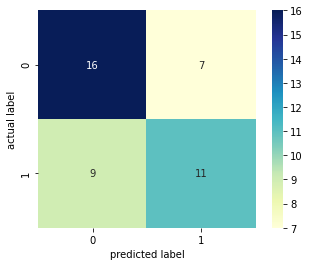

In [31]:
######################################## Load the TPOT Model ###################################################
with open("Saved Models/tpot_model.pickle", "rb") as f:
    tpot_args = pickle.load(f)

loaded_tpot = TPOTClassifier(template=tpot_args["template"])
tpot_args["fitted_pipeline_"] = tpot_args["template"]
del tpot_args["template"]
for k, v in tpot_args.items():
    setattr(loaded_tpot, k, v)
    
# Accuracy Score
print("________________________________________________________________________")
print("TPOT Score: ",loaded_tpot.score(x_test, y_test))

'''
########################################################################################################################
Make Predictions
########################################################################################################################
'''
output_ = strategy_returns(loaded_tpot, x_test, test_returns)

# Compare average returns given by the model, compared to average returns overall
try:
    strat_avg = output_[0]
except:
    strat_avg = 0
    
try:
    passive_avg = output_[1]
except:
    passive_avg = 0

print("________________________________________________________________________")
print("TPOT Strategy returns avg of: ",strat_avg)
print("Investing in all stocks returns avg of: ",passive_avg)

'''
########################################################################################################################
ROC Score
########################################################################################################################
'''
print("________________________________________________________________________")
print("ROC AUC Score: ",roc_auc_score(y_test, output_[2]))

'''
########################################################################################################################
Classification Report
########################################################################################################################
'''
print("________________________________________________________________________")
print("Classification Report: ")
print(classification_report(y_test, output_[2], zero_division=0))


'''
########################################################################################################################
Plot Confusion Matrix
########################################################################################################################
'''
print("________________________________________________________________________")
print("Confusion Matrix: ")

# make a confusion matrix to display the results
cm = confusion_matrix(y_test, output_[2])
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

## AutoKeras for Neural Network

AutoKeras is similar to TPOT in that it is an automated ML tool.  One advantage to TPOT is that AutoKeras has neural network capabilities.  I use AutoKeras below to test out different neural networks and save the best one.

I evaluate it using the same metrics as above.

In [54]:
result_combined = pd.read_excel("Code Inputs and Outputs/Cleaned Combined ML Data 2021-10-08.xlsx", index_col=0)

############################### Train Test Split ################################
result_combined = result_combined.drop(['co'], axis=1)

# Set y Values
y = result_combined['target']
result_combined = result_combined.drop(['target'], axis=1)

# Spit the dataset into x_train, x_test, y_train, y_test.  
x_train, x_test, y_train, y_test = train_test_split(result_combined, y, test_size=0.1, random_state=42, shuffle=True)

x_train = x_train.drop(['returns'], axis=1)
test_returns = x_test['returns']
x_test = x_test.drop(['returns'], axis=1)

# Normalize the data by subratcing the mean from each feature and divid by one standard deviation
mean = x_train.mean(axis = 0)
x_train -= mean

std = x_train.std(axis = 0)
x_train /= std

x_test -= mean
x_test /= std

print(x_train.shape)
print(x_test.shape)

(384, 290)
(43, 290)


In [55]:
# It tries 100 different models.
clf = ak.StructuredDataClassifier(overwrite=False, max_trials=100)
# Feed the structured data classifier with training data.
clf.fit(x_train, y_train, epochs=100)
# Predict with the best model.
predicted_y = clf.predict(x_test)
# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))

Trial 98 Complete [00h 00m 09s]
val_accuracy: 0.609375

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 14m 36s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
12/12 [==============================] - 3s 5ms/step - loss: 0.7328 - accuracy: 0.4978
Epoch 2/100
12/12 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.7019
Epoch 3/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5917 - accuracy: 0.7450
Epoch 4/100
12/12 [==============================] - 0s 5ms/step - loss: 0.5590 - accuracy: 0.7936
Epoch 5/100
12/12 [==============================] - 0s 5ms/step - loss: 0.5293 - accuracy: 0.8015
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 0.5025 - accuracy: 0.8367
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.4758 - accuracy: 0.8620
Epoch 8/100
12/12 [==============================] - 0s 5ms/step - loss: 0.4487 - accuracy: 0.8645
Epoch 9/100
12/12 [==============================] -

12/12 [==============================] - 0s 5ms/step - loss: 0.0087 - accuracy: 0.9994
Epoch 82/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0078 - accuracy: 0.9991
Epoch 83/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0086 - accuracy: 0.9990
Epoch 84/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0072 - accuracy: 0.9991
Epoch 85/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0111 - accuracy: 0.9937
Epoch 86/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 0.9991
Epoch 87/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0179 - accuracy: 0.9937
Epoch 88/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0060 - accuracy: 0.9991
Epoch 89/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0106 - accuracy: 0.9937
Epoch 90/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0061 - accuracy: 0.9991
Epoch 91/100


In [56]:
########################### Save the Model #############################################
# Export
model = clf.export_model()

# Save
try:
    model.save("Saved Models/AutoKeras/AutoKeras_1", save_format="tf")
except Exception:
    model.save("Saved Models/AutoKeras/AutoKeras_1.h5")

INFO:tensorflow:Assets written to: Saved Models/AutoKeras/AutoKeras_1\assets


________________________________________________________________________
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 290)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 290)               0         
_________________________________________________________________
normalization (Normalization (None, 290)               581       
_________________________________________________________________
dense (Dense)                (None, 32)                9312      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
______________________________________________________

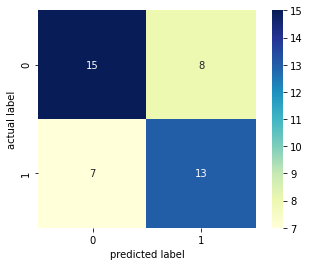

In [57]:
######################################## Load the AutoKeras Model ###################################################
# Load in the model
loaded_model = load_model("Saved Models/AutoKeras/AutoKeras_1", custom_objects=ak.CUSTOM_OBJECTS)
# Show Summary
print("________________________________________________________________________")
print(loaded_model.summary())
    
# Accuracy Score
print("________________________________________________________________________")
print("AutoKeras Score: ",loaded_model.evaluate(x_test, y_test, verbose=0)[1])

'''
########################################################################################################################
Make Predictions
########################################################################################################################
'''
output_ = strategy_returns(loaded_model, x_test, test_returns)

# Compare average returns given by the model, compared to average returns overall
try:
    strat_avg = output_[0]
except:
    strat_avg = 0
    
try:
    passive_avg = output_[1]
except:
    passive_avg = 0

print("________________________________________________________________________")
print("AutoKeras Strategy returns avg of: ",strat_avg)
print("Investing in all stocks returns avg of: ",passive_avg)

'''
########################################################################################################################
ROC Score
########################################################################################################################
'''
print("________________________________________________________________________")
print("ROC AUC Score: ",roc_auc_score(y_test, output_[3]))

'''
########################################################################################################################
Classification Report
########################################################################################################################
'''
print("________________________________________________________________________")
print("Classification Report: ")
print(classification_report(y_test, output_[3], zero_division=0))


'''
########################################################################################################################
Plot Confusion Matrix
########################################################################################################################
'''
print("________________________________________________________________________")
print("Confusion Matrix: ")

# make a confusion matrix to display the results
cm = confusion_matrix(y_test, output_[3])
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

## Multilayer Perceptron

In this section I create my own neural network - a multilayer perceptron.  

I evaluate it with the same metrics as above.

Epoch 1/100
10/10 [==============================] - 2s 36ms/step - loss: 2.0891 - accuracy: 0.5373 - val_loss: 1.9595 - val_accuracy: 0.4545
Epoch 2/100
10/10 [==============================] - 0s 9ms/step - loss: 1.7929 - accuracy: 0.7479 - val_loss: 1.9713 - val_accuracy: 0.4286
Epoch 3/100
10/10 [==============================] - 0s 8ms/step - loss: 1.5974 - accuracy: 0.8720 - val_loss: 1.9778 - val_accuracy: 0.4416
Epoch 4/100
10/10 [==============================] - 0s 11ms/step - loss: 1.5651 - accuracy: 0.8609 - val_loss: 1.9591 - val_accuracy: 0.4935
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 1.5599 - accuracy: 0.8815 - val_loss: 1.9444 - val_accuracy: 0.5455
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 1.4870 - accuracy: 0.9328 - val_loss: 1.9499 - val_accuracy: 0.5065
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 1.3999 - accuracy: 0.9377 - val_loss: 1.9371 - val_accuracy: 0.5195
Epoch 8/10

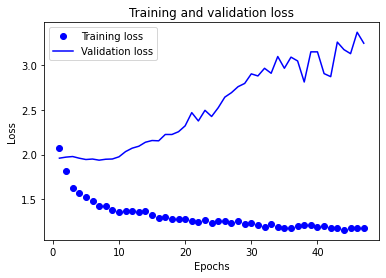

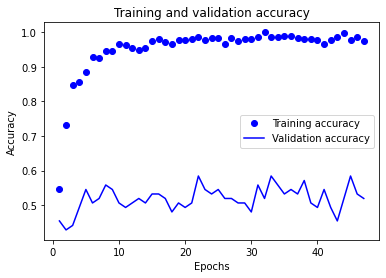

['loss', 'accuracy']
[1.8998188972473145, 0.6744186282157898]


In [37]:
'''
Setup

'''
result_combined = pd.read_excel("Code Inputs and Outputs/Cleaned Combined ML Data 2021-10-08.xlsx", index_col=0)

############################### Train Test Split ################################
result_combined = result_combined.drop(['co'], axis=1)

# Set y Values
y = result_combined['target']
result_combined = result_combined.drop(['target'], axis=1)

# Spit the dataset into x_train, x_test, y_train, y_test.  
x_train, x_test, y_train, y_test = train_test_split(result_combined, y, test_size=0.1, random_state=42, shuffle=True)

x_train = x_train.drop(['returns'], axis=1)
test_returns = x_test['returns']
x_test = x_test.drop(['returns'], axis=1)

# Normalize the data by subratcing the mean from each feature and divid by one standard deviation
mean = x_train.mean(axis = 0)
x_train -= mean

std = x_train.std(axis = 0)
x_train /= std

x_test -= mean
x_test /= std

'''
Model Construction and training

'''

backend.clear_session()
# Initialize 
model = models.Sequential()
model.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1(.0001),input_shape = x_train.iloc[0,:].shape))
model.add(BatchNormalization())

# Hidden Layers
model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(.0001), activation = 'relu'))
model.add(BatchNormalization())

model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(.0001), activation = 'relu'))
model.add(BatchNormalization())

model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(.0001), activation = 'relu'))
model.add(BatchNormalization())

model.add(layers.Dense(64, kernel_regularizer=regularizers.l1(.0001), activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.2))

# Output Layer.  Use one node becuase it is a binary classification problem
model.add(layers.Dense(1, activation = 'sigmoid'))

# Compile the model
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

# Fit the model.  Validation split and early stopping.
history = model.fit(x_train,
                   y_train,
                   epochs = 100,
                   batch_size = 32,
                   validation_split=0.2,
                   verbose = 1,
                   callbacks=[EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights = True)])

# Save result and plot them
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

results = model.evaluate(x_test, y_test, verbose=0)
print(model.metrics_names)
print(results)

model.save('Saved Models/standalone_MLP.h5')

________________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               37248     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________

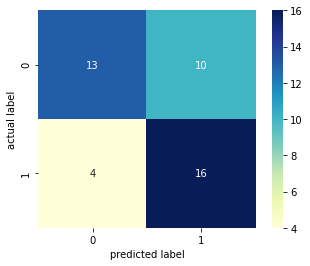

In [38]:
######################################## Load the MLP Model ###################################################
model = load_model('Saved Models/standalone_MLP.h5')
# Show Summary
print("________________________________________________________________________")
print(model.summary())
    
# Accuracy Score
print("________________________________________________________________________")
print("MLP Score: ",model.evaluate(x_test, y_test, verbose=0)[1])

'''
########################################################################################################################
Make Predictions
########################################################################################################################
'''
output_ = strategy_returns(model, x_test, test_returns)

# Compare average returns given by the model, compared to average returns overall
try:
    strat_avg = output_[0]
except:
    strat_avg = 0
    
try:
    passive_avg = output_[1]
except:
    passive_avg = 0

print("________________________________________________________________________")
print("MLP Strategy returns avg of: ",strat_avg)
print("Investing in all stocks returns avg of: ",passive_avg)

'''
########################################################################################################################
ROC Score
########################################################################################################################
'''
print("________________________________________________________________________")
print("ROC AUC Score: ",roc_auc_score(y_test, output_[3]))

'''
########################################################################################################################
Classification Report
########################################################################################################################
'''
print("________________________________________________________________________")
print("Classification Report: ")
print(classification_report(y_test, output_[3], zero_division=0))


'''
########################################################################################################################
Plot Confusion Matrix
########################################################################################################################
'''
print("________________________________________________________________________")
print("Confusion Matrix: ")

# make a confusion matrix to display the results
cm = confusion_matrix(y_test, output_[3])
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

## Random Forest Classifier

Here, I create a Random Forest classifier and evaluate it with the same metrics as above, plus K-fold cross-validation.

In [45]:
result_combined = pd.read_excel("Code Inputs and Outputs/Cleaned Combined ML Data 2021-10-08.xlsx", index_col=0)

############################### Train Test Split ################################
result_combined = result_combined.drop(['co'], axis=1)

# Set y Values
y = result_combined['target']
result_combined = result_combined.drop(['target'], axis=1)

# Spit the dataset into x_train, x_test, y_train, y_test.  
x_train, x_test, y_train, y_test = train_test_split(result_combined, y, random_state=42, test_size=0.1, shuffle=True)

x_train = x_train.drop(['returns'], axis=1)
test_returns = x_test['returns']
x_test = x_test.drop(['returns'], axis=1)

# Normalize the data by subratcing the mean from each feature and divid by one standard deviation
mean = x_train.mean(axis = 0)
x_train -= mean

std = x_train.std(axis = 0)
x_train /= std

x_test -= mean
x_test /= std

# Create the model
#using the sklearn.metrics package to determine the accuracy of the model
forest_model = RandomForestClassifier(n_jobs = -1)
forest_model.fit(x_train,y_train)

# Save the model
with open('Saved Models/standalone_RF', 'wb') as f:
    pickle.dump(forest_model, f)

________________________________________________________________________
RF Accuracy:  0.6744186046511628
Average cross-validation score: 0.5547
________________________________________________________________________
RF Strategy returns avg of:  0.20646550635233427
Investing in all stocks returns avg of:  0.14031345829604572
________________________________________________________________________
ROC AUC Score:  0.6728260869565217
________________________________________________________________________
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        23
           1       0.65      0.65      0.65        20

    accuracy                           0.67        43
   macro avg       0.67      0.67      0.67        43
weighted avg       0.67      0.67      0.67        43

________________________________________________________________________
Confusion Matrix: 


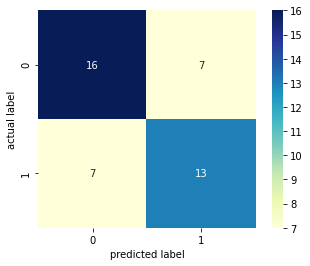

In [47]:
with open('Saved Models/standalone_RF', 'rb') as f:
    forest_model = pickle.load(f)
    
#gathering the predictions
forest_preds = forest_model.predict(x_test)

print("________________________________________________________________________")
print("RF Accuracy: ",accuracy_score(y_test,forest_preds))

'''
########################################################################################################################
K-Fold Cross Validation
########################################################################################################################
'''

# Applying 10-Fold Cross Validation
scores = cross_val_score(forest_model, x_train, y_train, cv = 2, scoring='accuracy')

# compute Average cross-validation score

print('Average cross-validation score: {:.4f}'.format(scores.mean()))

'''
########################################################################################################################
Comparing Strategy to Benchmark
########################################################################################################################
'''

output_ = strategy_returns(forest_model, x_test, test_returns)

# Compare average returns given by the model, compared to average returns overall
try:
    strat_avg = output_[0]
except:
    strat_avg = 0
    
try:
    passive_avg = output_[1]
except:
    passive_avg = 0

print("________________________________________________________________________")
print("RF Strategy returns avg of: ",strat_avg)
print("Investing in all stocks returns avg of: ",passive_avg)

'''
########################################################################################################################
ROC Score
########################################################################################################################
'''
print("________________________________________________________________________")
print("ROC AUC Score: ",roc_auc_score(y_test, forest_preds))

'''
########################################################################################################################
Classification Report
########################################################################################################################
'''
print("________________________________________________________________________")
print("Classification Report")
print(classification_report(y_test, forest_preds, zero_division=0))

'''

########################################################################################################################
Confusion Matrix
########################################################################################################################
'''
print("________________________________________________________________________")
print("Confusion Matrix: ")

# make a confusion matrix to display the results
cm = confusion_matrix(y_test, forest_preds)
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

## Convolutional Neural Network

Finally, I wanted to see how a convolutional neural network (CNN) would handle my data.  First I had to structure the data differently than I have before, as I am using 2D Convolutional layers in my model.  These require a 2D input shape.  Before, the data is just in a dataframe.  I convert each row of the dataframe to be a 10 row by 29 column dataframe, and then convert that to an array.  The 10 rows are 10 years of data and the 290 columns are the financial metrics that are the features.

I contsruct, train, and evaluate the model as before.

Epoch 1/100
10/10 [==============================] - 3s 202ms/step - loss: 2.9957 - accuracy: 0.5400 - val_loss: 2.8503 - val_accuracy: 0.4026
Epoch 2/100
10/10 [==============================] - 2s 166ms/step - loss: 2.8194 - accuracy: 0.6182 - val_loss: 2.7179 - val_accuracy: 0.4156
Epoch 3/100
10/10 [==============================] - 2s 182ms/step - loss: 2.5987 - accuracy: 0.6745 - val_loss: 2.6430 - val_accuracy: 0.4805
Epoch 4/100
10/10 [==============================] - 2s 198ms/step - loss: 2.4558 - accuracy: 0.7480 - val_loss: 2.5548 - val_accuracy: 0.4416
Epoch 5/100
10/10 [==============================] - 2s 172ms/step - loss: 2.3662 - accuracy: 0.7148 - val_loss: 2.5525 - val_accuracy: 0.3766
Epoch 6/100
10/10 [==============================] - 2s 169ms/step - loss: 2.2197 - accuracy: 0.8034 - val_loss: 2.4950 - val_accuracy: 0.4416
Epoch 7/100
10/10 [==============================] - 2s 171ms/step - loss: 2.1953 - accuracy: 0.8260 - val_loss: 2.4626 - val_accuracy: 0.4675

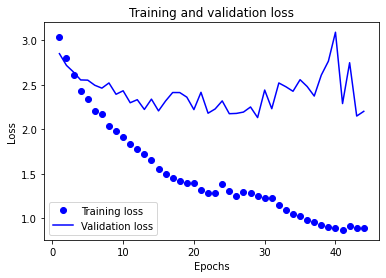

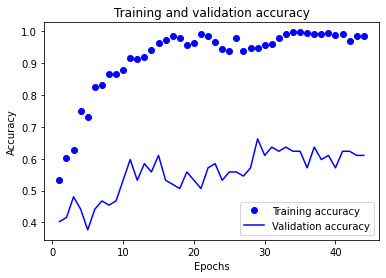

['loss', 'accuracy']
[2.4930834770202637, 0.6744186282157898]


In [48]:
result_combined = pd.read_excel("Code Inputs and Outputs/Cleaned Combined ML Data 2021-10-08.xlsx", index_col=0)

############################### Train Test Split ################################
result_combined = result_combined.drop(['co'], axis=1)

# Set y Values
y = result_combined['target']
result_combined = result_combined.drop(['target'], axis=1)

# Spit the dataset into x_train, x_test, y_train, y_test.  
x_train, x_test, y_train, y_test = train_test_split(result_combined, y, random_state=42, test_size=0.1, shuffle=True)

x_train = x_train.drop(['returns'], axis=1)
test_returns = x_test['returns']
x_test = x_test.drop(['returns'], axis=1)

# Normalize the data by subratcing the mean from each feature and divid by one standard deviation
mean = x_train.mean(axis = 0)
x_train -= mean

std = x_train.std(axis = 0)
x_train /= std

x_test -= mean
x_test /= std

'''
Structure Data for 2D Convolutional Layers

'''

# First convert the training data
# Convert dataframe to an array of arrays.  Each row of the dataframe becomes a 2d matrix array.  
#The main array holds each row-turned-array

big_train_list = []

# For each row in the dataframe
for x in range(len(x_train.index)):
    row = x_train.iloc[x,:]
    
    # Initialize a temporary data frame of 29 rows (feature) and 10 columns (for each year of data)
    temp_df = pd.DataFrame(index=range(29),columns=range(10))

    temp_row = 0
    temp_col = 0
    counter = 0

    # Go through each item in the row
    for item in row:

        # Put the item from the row into the temp df
        temp_df.loc[temp_row, temp_col] = item

        # Update row, column positioning
        counter += 1
        if counter % 10 == 0:
            temp_row += 1
        temp_col = counter % 10

    # Convert the temp_df into an array
    temp_np = temp_df.to_numpy()
    # Add each array to the list
    big_train_list.append(temp_np)
    
# Convert List of Arrays into an array of arrays
big_train_array = np.array(big_train_list)

# Second, convert the test_data.  Same process as for train data
big_test_list = []

for x in range(len(x_test.index)):
    row = x_test.iloc[x,:]
    
    temp_df = pd.DataFrame(index=range(29),columns=range(10))

    temp_row = 0
    temp_col = 0
    counter = 0

    for item in row:

        temp_df.loc[temp_row, temp_col] = item

        counter += 1
        if counter % 10 == 0:
            temp_row += 1
        temp_col = counter % 10

    temp_np = temp_df.to_numpy()
    big_test_list.append(temp_np)
    
big_test_array = np.array(big_test_list)

# Save new arrays as the x_train and x_test to use in the model
x_train = big_train_array
x_test = big_test_array

# Convert to Float
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')

# Add 3rd Dimension so that it can be inputted into the ConvNet
x_train = np.expand_dims(x_train, 3)
x_test = np.expand_dims(x_test, 3)

'''
#############################################################################################
Initialize and Train the model
#############################################################################################

'''
backend.clear_session()
model = models.Sequential()
model.add(layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l1(.0001), activation = 'relu',padding='same', input_shape = x_train[0].shape))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(256, (3,3), kernel_regularizer=regularizers.l1(.0001), activation = 'relu',padding='same'))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(256, (3,3), kernel_regularizer=regularizers.l1(.0001), activation = 'relu',padding='same'))
model.add(layers.MaxPool2D((2,2)))
model.add(BatchNormalization())

model.add(layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l1(.0001), activation = 'relu',padding='same'))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = 'adam',
               loss = 'binary_crossentropy',
               metrics = ['accuracy'])

# Fit the model.
history = model.fit(x_train,
                   y_train,
                   epochs = 100,
                   validation_split=0.2,
                   verbose = 1,
                   callbacks=[EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights = True)])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

results = model.evaluate(x_test, y_test, verbose=0)
print(model.metrics_names)
print(results)

model.save('Saved Models/standalone_CNN.h5')

________________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 29, 10, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 5, 128)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 5, 128)        512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 5, 256)        295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 2, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 2, 256)         1024      
_________________________________________________

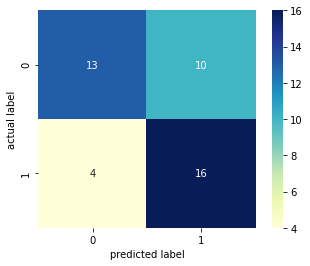

In [49]:
######################################## Load the CNN Model ###################################################
model = load_model('Saved Models/standalone_CNN.h5')
# Show Summary
print("________________________________________________________________________")
print(model.summary())
    
# Accuracy Score
print("________________________________________________________________________")
print("CNN Score: ",model.evaluate(x_test, y_test, verbose=0)[1])

'''
########################################################################################################################
Make Predictions
########################################################################################################################
'''
output_ = strategy_returns(model, x_test, test_returns)

# Compare average returns given by the model, compared to average returns overall
try:
    strat_avg = output_[0]
except:
    strat_avg = 0
    
try:
    passive_avg = output_[1]
except:
    passive_avg = 0

print("________________________________________________________________________")
print("CNN Strategy returns avg of: ",strat_avg)
print("Investing in all stocks returns avg of: ",passive_avg)

'''
########################################################################################################################
ROC Score
########################################################################################################################
'''
print("________________________________________________________________________")
print("ROC AUC Score: ",roc_auc_score(y_test, output_[3]))

'''
########################################################################################################################
Classification Report
########################################################################################################################
'''
print("________________________________________________________________________")
print("Classification Report: ")
print(classification_report(y_test, output_[3], zero_division=0))

'''
########################################################################################################################
Plot Confusion Matrix
########################################################################################################################
'''
print("________________________________________________________________________")
print("Confusion Matrix: ")

# make a confusion matrix to display the results
cm = confusion_matrix(y_test, output_[3])
target_labels = np.unique(y_test)

sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap="YlGnBu",
            xticklabels=target_labels, yticklabels=target_labels)

plt.xlabel('predicted label')
plt.ylabel('actual label');

## Iterate Models and Save them

When I was training the models above, I would notice some variations for accuracy when I would train the model different times. I decided it would be better to see what an ensemble of each model performed, than just a single model.  Below, I run the MLP, RF, and CNN models iteratively, 10 times and with different train/test data each time.  I evaluate the models by averaging the results of the iterations.

### Multilayer Perceptron

In [50]:
models_list = []
losses = []
accuracies = []
model_returns = []
overall_returns = []


for x in tqdm(range(10)): 
    ############################### Train Test Split ################################
    result_combined = pd.read_excel("Code Inputs and Outputs/Cleaned Combined ML Data 2021-10-08.xlsx", index_col=0)
    result_combined = result_combined.drop(['co'], axis=1)

    # Set y Values
    y = result_combined['target']
    result_combined = result_combined.drop(['target'], axis=1)

    # Spit the dataset into x_train, x_test, y_train, y_test.  
    x_train, x_test, y_train, y_test = train_test_split(result_combined, y, test_size=0.1, shuffle=True)

    x_train = x_train.drop(['returns'], axis=1)
    test_returns = x_test['returns']
    x_test = x_test.drop(['returns'], axis=1)

    # Normalize the data by subratcing the mean from each feature and divid by one standard deviation
    mean = x_train.mean(axis = 0)
    x_train -= mean

    std = x_train.std(axis = 0)
    x_train /= std

    x_test -= mean
    x_test /= std
    
    backend.clear_session()

    # Initialize 
    model = models.Sequential()
    model.add(layers.Dense(128, activation = 'relu', kernel_regularizer=regularizers.l1(.0001),input_shape = (290,)))
    model.add(BatchNormalization())

    # Hidden Layers
    model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(.0001), activation = 'relu'))
    model.add(BatchNormalization())
    
    model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(.0001), activation = 'relu'))
    model.add(BatchNormalization())

    model.add(layers.Dense(256, kernel_regularizer=regularizers.l1(.0001), activation = 'relu'))
    model.add(BatchNormalization())

    model.add(layers.Dense(64, kernel_regularizer=regularizers.l1(.0001), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(layers.Dropout(0.2))

    # Output Layer.  Use one node becuase it is a binary classification problem
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Compile the model
    model.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics = ['accuracy'])
    
    # Fit the model.  Validation split and early stopping.
    history = model.fit(x_train,
                       y_train,
                       epochs = 100,
                       batch_size = 32,
                       validation_split=0.2,
                       verbose = 0,
                       callbacks=[EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights = True)])
    
    results = model.evaluate(x_test, y_test, verbose=0)
    
    models_list.append(model)
    losses.append(results[0])
    accuracies.append(results[1])
    model_returns.append(strategy_returns(model, x_test, test_returns)[0])
    overall_returns.append(strategy_returns(model, x_test, test_returns)[1])
    
for x in range(len(models_list)):
    models_list[x].save('Saved Models/MultiLayerPerceptron/MultiLayerPerceptron_'+str(x)+'.h5')
    
print("__________________________________________________________________________________________")
print("Multilayer Perceptron Accuracies: ", accuracies)
print("Multilayer Perceptron Mean Accuracy: ", statistics.mean(accuracies))
print("Multilayer Perceptron Mean Strategy Return: ", statistics.mean(model_returns))
print("Multilayer Perceptron Mean Passive Return: ", statistics.mean(overall_returns))

 10%|█         | 1/10 [00:06<01:02,  6.89s/it]

100%|██████████| 10/10 [01:12<00:00,  7.20s/it]


__________________________________________________________________________________________
Multilayer Perceptron Accuracies:  [0.6279069781303406, 0.6744186282157898, 0.5116279125213623, 0.6744186282157898, 0.6511628031730652, 0.6279069781303406, 0.5581395626068115, 0.6279069781303406, 0.5581395626068115, 0.5116279125213623]
Multilayer Perceptron Mean Accuracy:  0.6023255944252014
Multilayer Perceptron Mean Strategy Return:  0.36222880496144005
Multilayer Perceptron Mean Passive Return:  0.250381072696022


### Random Forest

In [51]:
models_list = []
accuracies = []
model_returns = []
overall_returns = []

for x in tqdm(range(10)): 
    ############################### Train Test Split ################################
    result_combined = pd.read_excel("Code Inputs and Outputs/Cleaned Combined ML Data 2021-10-08.xlsx", index_col=0)
    result_combined = result_combined.drop(['co'], axis=1)

    # Set y Values
    y = result_combined['target']
    result_combined = result_combined.drop(['target'], axis=1)

    # Spit the dataset into x_train, x_test, y_train, y_test.  
    x_train, x_test, y_train, y_test = train_test_split(result_combined, y, test_size=0.1, shuffle=True)

    x_train = x_train.drop(['returns'], axis=1)
    test_returns = x_test['returns']
    x_test = x_test.drop(['returns'], axis=1)

    # Normalize the data by subratcing the mean from each feature and divid by one standard deviation
    mean = x_train.mean(axis = 0)
    x_train -= mean

    std = x_train.std(axis = 0)
    x_train /= std

    x_test -= mean
    x_test /= std
    
    # Create the model
    #using the sklearn.metrics package to determine the accuracy of the model
    forest_model = RandomForestClassifier(n_jobs = -1)
    forest_model.fit(x_train,y_train)

    #gathering the predictions
    forest_preds = forest_model.predict(x_test)
    
    models_list.append(forest_model)
    accuracies.append(accuracy_score(y_test,forest_preds))
    model_returns.append(strategy_returns(forest_model, x_test, test_returns)[0])
    overall_returns.append(strategy_returns(forest_model, x_test, test_returns)[1])
    
for x in range(len(models_list)):
    joblib.dump(models_list[x], "Saved Models/RandomForest/random_forest_"+str(x)+".joblib")
    
print("__________________________________________________________________________________________")
print("RF Accuracies: ", accuracies)
print("RF Mean Accuracy: ", statistics.mean(accuracies))
print("RF Mean Strategy Return: ", statistics.mean(model_returns))
print("RF Mean Passive Return: ", statistics.mean(overall_returns))

100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


__________________________________________________________________________________________
RF Accuracies:  [0.627906976744186, 0.5348837209302325, 0.6976744186046512, 0.627906976744186, 0.6744186046511628, 0.6046511627906976, 0.4186046511627907, 0.5813953488372093, 0.6976744186046512, 0.6744186046511628]
RF Mean Accuracy:  0.6139534883720931
RF Mean Strategy Return:  0.29681338785524136
RF Mean Passive Return:  0.20919245974628334


### ConvNet

In [52]:
models_list = []
losses = []
accuracies = []
model_returns = []
overall_returns = []


for x in tqdm(range(10)): 
    ############################### Train Test Split ################################
    result_combined = pd.read_excel("Code Inputs and Outputs/Cleaned Combined ML Data 2021-10-08.xlsx", index_col=0)
    result_combined = result_combined.drop(['co'], axis=1)

    # Set y Values
    y = result_combined['target']
    result_combined = result_combined.drop(['target'], axis=1)

    # Spit the dataset into x_train, x_test, y_train, y_test.  
    x_train, x_test, y_train, y_test = train_test_split(result_combined, y, test_size=0.1, shuffle=True)

    x_train = x_train.drop(['returns'], axis=1)
    test_returns = x_test['returns']
    x_test = x_test.drop(['returns'], axis=1)

    # Normalize the data by subratcing the mean from each feature and divid by one standard deviation
    mean = x_train.mean(axis = 0)
    x_train -= mean

    std = x_train.std(axis = 0)
    x_train /= std

    x_test -= mean
    x_test /= std
    
    # First convert the training data
    # Convert dataframe to an array of arrays.  Each row of the dataframe becomes a 2d matrix array.  
    #The main array holds each row-turned-array

    big_train_list = []

    # For each row in the dataframe
    for x in range(len(x_train.index)):
        row = x_train.iloc[x,:]

        # Initialize a temporary data frame of 29 rows (feature) and 10 columns (for each year of data)
        temp_df = pd.DataFrame(index=range(29),columns=range(10))

        temp_row = 0
        temp_col = 0
        counter = 0

        # Go through each item in the row
        for item in row:

            # Put the item from the row into the temp df
            temp_df.loc[temp_row, temp_col] = item

            # Update row, column positioning
            counter += 1
            if counter % 10 == 0:
                temp_row += 1
            temp_col = counter % 10

        # Convert the temp_df into an array
        temp_np = temp_df.to_numpy()
        # Add each array to the list
        big_train_list.append(temp_np)

    # Convert List of Arrays into an array of arrays
    big_train_array = np.array(big_train_list)
    
    # Second, convert the test_data.  Same process as for train data
    big_test_list = []

    for x in range(len(x_test.index)):
        row = x_test.iloc[x,:]

        temp_df = pd.DataFrame(index=range(29),columns=range(10))

        temp_row = 0
        temp_col = 0
        counter = 0

        for item in row:

            temp_df.loc[temp_row, temp_col] = item

            counter += 1
            if counter % 10 == 0:
                temp_row += 1
            temp_col = counter % 10

        temp_np = temp_df.to_numpy()
        big_test_list.append(temp_np)

    big_test_array = np.array(big_test_list)
    
    # Save new arrays as the x_train and x_test to use in the model
    x_train = big_train_array
    x_test = big_test_array

    # Convert to Float
    x_train = np.asarray(x_train).astype('float32')
    x_test = np.asarray(x_test).astype('float32')

    # Add 3rd Dimension so that it can be inputted into the ConvNet
    x_train = np.expand_dims(x_train, 3)
    x_test = np.expand_dims(x_test, 3)

    backend.clear_session()
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l1(.0001), activation = 'relu',padding='same', input_shape = x_train[0].shape))
    model.add(layers.MaxPool2D((2,2)))
    model.add(BatchNormalization())

    model.add(layers.Conv2D(256, (3,3), kernel_regularizer=regularizers.l1(.0001), activation = 'relu',padding='same'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(BatchNormalization())

    model.add(layers.Conv2D(256, (3,3), kernel_regularizer=regularizers.l1(.0001), activation = 'relu',padding='same'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(BatchNormalization())

    model.add(layers.Conv2D(128, (3,3), kernel_regularizer=regularizers.l1(.0001), activation = 'relu',padding='same'))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer = 'adam',
                   loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

    # Fit the model.
    history = model.fit(x_train,
                       y_train,
                       epochs = 100,
                       validation_split=0.2,
                       verbose = 0,
                       callbacks=[EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights = True)])
    
    results = model.evaluate(x_test, y_test, verbose=0)
    
    models_list.append(model)
    losses.append(results[0])
    accuracies.append(results[1])
    
    model_returns.append(strategy_returns(model, x_test, test_returns)[0])
    overall_returns.append(strategy_returns(model, x_test, test_returns)[1])
    

# Save all the models
for x in range(len(models_list)):
    models_list[x].save('Saved Models/ConvNet/ConvNet_'+str(x)+'.h5')
    
print("__________________________________________________________________________________________")
print("ConvNet Accuracies: ", accuracies)
print("ConvNet Mean Accuracy: ", statistics.mean(accuracies))
print("ConvNet Mean Strategy Return: ", statistics.mean(model_returns))
print("ConvNet Mean Passive Return: ", statistics.mean(overall_returns))


100%|██████████| 10/10 [19:25<00:00, 116.59s/it]


__________________________________________________________________________________________
ConvNet Accuracies:  [0.4883720874786377, 0.604651153087616, 0.5813953280448914, 0.5581395626068115, 0.604651153087616, 0.6279069781303406, 0.5813953280448914, 0.4651162922382355, 0.5581395626068115, 0.5348837375640869]
ConvNet Mean Accuracy:  0.5604651182889938
ConvNet Mean Strategy Return:  0.34438708328182244
ConvNet Mean Passive Return:  0.25728716792196615


## 5. Database Updater

This is run periodically to ensure that the database is up to date.  The last update date is saved and the QuickFS functionality allows me to get a list of companies updated since that time.  

For the companies that need to be updated, I download the data from QuickFS, compare to what I have in the database, and combine the existing data with new data to be the new entry for that company in MongoDB.

This is done for all countries in the database, and annually and quarterly data.

In [17]:
#LastUpdate: 20211008
date = '20211003'

# create connection 
client = MongoClient()
client_name = "MSDS_692_Project"
db = client[client_name]

codes = ['US','AU','CA','LN','MM','NZ']
periods = ['FQ','FY']

# For FY and FQ
for period in periods:

    if period == "FY":
            timeframe = "FY-19:FY"
            collection_names = ['US_FY','Australia_FY', 'Canada_FY', 'London_FY', 'Mexico_FY', 'NewZealand_FY']
    elif period == "FQ":
        timeframe = "FQ-79:FQ"
        collection_names = ['US_FQ','Australia_FQ', 'Canada_FQ', 'London_FQ', 'Mexico_FQ', 'NewZealand_FQ']

    for x in range(len(collection_names)):
        print(collection_names[x])
        collection = db[collection_names[x]]
        code = codes[x]
        collection_name = collection_names[x]

        cos_updated = 0

        ################################## Get list of updated cos #########################

        r = requests.get('https://public-api.quickfs.net/v1/companies/updated/'+date+'/'+code,headers=header)
        #if r.status_code != 200:
        #    print(r.status_code, r.reason)
        x = r.json()
        if len(x) == 0:
            updated_Cos = []
        else:
            updated_Cos = x['data']
        ############################### Get list of cos in mongodb #######################
        Mongo_Cos = []
        query = {'ticker': { "$regex":':'+code} }
        selection = collection.find(query)
        for doc in tqdm(selection):
            Mongo_Cos.append(doc['ticker'])
        ######################## compare list and create new list of cos on both previous lists ############
        Cos_to_update = set(Mongo_Cos).intersection(updated_Cos)

        ######################## Loop and Update ###################
        for co in tqdm(Cos_to_update):
            #Download QFS Dates
            request_body = {
                "data" : {
                    co: {
                        "original_filing_date" : "QFS("+co+",original_filing_date,"+timeframe+")"
                     }
                }
            }
            r = requests.post("https://public-api.quickfs.net/v1/data/batch",json=request_body,headers=header)
            if r.status_code != 200:
                print(r.status_code, r.reason)
            my_data = r.json()

            # Turn blanks into NaNs
            QFS_original_filing_date = []
            for x in range(len(my_data['data'][co]['original_filing_date'])):    
                if '20' not in str(my_data['data'][co]['original_filing_date'][x]):
                    QFS_original_filing_date.append(float("NaN"))
                else:
                    QFS_original_filing_date.append(my_data['data'][co]['original_filing_date'][x])

            # Mongo Query to save all dates in list
            query = {'ticker': { "$eq":co} }
            selection = collection.find(query)
            for doc in selection:
                Mongo_original_filing_date = doc["original_filing_date"]

            # Create List of New Dates
            new_dates = np.setdiff1d(QFS_original_filing_date,Mongo_original_filing_date)

            # If Dates added
            if len(new_dates) > 0:
                # Download QFS Data
                if datapoints_remaining(header) > 10:
                    #Download Data
                    my_dict = batch_download(header,co, period)

                else:
                    print("No API Calls Remaining")
                    print(cos_updated,"Companies Updated")
                    break

                # Import MongoDB Data
                query = {'ticker': { "$eq":co} }
                selection = collection.find(query)
                for doc in selection:
                    Mongo_original_filing_date = doc["original_filing_date"]
                    Mongo_roic = doc["roic"]
                    Mongo_total_equity_growth = doc["total_equity_growth"]
                    Mongo_eps_diluted_growth = doc["eps_diluted_growth"]
                    Mongo_revenue_growth = doc["revenue_growth"]
                    Mongo_revenue = doc["revenue"]
                    Mongo_fcf = doc["fcf"]
                    Mongo_lt_debt = doc["lt_debt"]
                    Mongo_fcf_growth = doc["fcf_growth"]
                    Mongo_payback_time = doc["payback_time"]

                    done = False
                    for x in range(len(my_dict['original_filing_date'])):
                        for y in range(len(Mongo_original_filing_date)):
                            if not done:
                                # Find the similar dates in the existing database and new data
                                # Save up to the new data as the existing data
                                if QFS_original_filing_date[x] == Mongo_original_filing_date[y] and QFS_original_filing_date[x] != np.nan:
                                    dates1 = Mongo_original_filing_date[:y]
                                    roic1 = Mongo_roic[:y]
                                    total_equity_growth1 = Mongo_total_equity_growth[:y]
                                    eps_diluted_growth1 = Mongo_eps_diluted_growth[:y]
                                    revenue_growth1 = Mongo_revenue_growth[:y]
                                    revenue1 = Mongo_revenue[:y]
                                    fcf_growth1 = Mongo_fcf_growth[:y]
                                    fcf1 = Mongo_fcf[:y]
                                    lt_debt1 = Mongo_lt_debt[:y]
                                    payback_time1 = Mongo_payback_time[:y]

                                    # Save the new data to the end as the new data
                                    dates2 = my_dict['original_filing_date'][x:]
                                    roic2 = my_dict['roic'][x:]
                                    total_equity_growth2 = my_dict['total_equity_growth'][x:]
                                    eps_diluted_growth2 = my_dict['eps_diluted_growth'][x:]
                                    revenue_growth2 = my_dict['revenue_growth'][x:]
                                    revenue2 = my_dict['revenue'][x:]
                                    fcf_growth2 = my_dict['fcf_growth'][x:]
                                    fcf2 = my_dict['fcf'][x:]
                                    lt_debt2 = my_dict['lt_debt'][x:]
                                    payback_time2 = my_dict['payback_time'][x:]

                                    # Combine Lists Into One
                                    original_filing_date = dates1 + dates2
                                    roic = roic1 + roic2
                                    total_equity_growth = total_equity_growth1 + total_equity_growth2
                                    eps_diluted_growth = eps_diluted_growth1 + eps_diluted_growth2
                                    revenue_growth = revenue_growth1 + revenue_growth2
                                    revenue = revenue1 + revenue2
                                    fcf_growth = fcf_growth1 + fcf_growth2 
                                    fcf = fcf1 + fcf2
                                    lt_debt  = lt_debt1 + lt_debt2
                                    payback_time = payback_time1 + payback_time2                                

                                    # update years, update date, averages
                                    periods = np.count_nonzero(~np.isnan(roic))
                                    update_time = datetime.now()

                                    roic_averages = avg_list(roic, period)
                                    total_equity_growth_averages = avg_list(total_equity_growth, period)
                                    eps_diluted_growth_averages = avg_list(eps_diluted_growth, period)
                                    revenue_growth_averages = avg_list(revenue_growth, period)
                                    fcf_growth_averages = avg_list(fcf_growth, period)

                                    # Update mongo db with combined lists and new years/updates/averages

                                    mongo_requests = [
                                        UpdateOne({'ticker':co},{"$set":{'update_time':update_time}}),
                                        UpdateOne({'ticker':co},{"$set":{'original_filing_date':original_filing_date}}),
                                        UpdateOne({'ticker':co},{"$set":{'roic':roic}}),
                                        UpdateOne({'ticker':co},{"$set":{'total_equity_growth':total_equity_growth}}),
                                        UpdateOne({'ticker':co},{"$set":{'eps_diluted_growth':eps_diluted_growth}}),
                                        UpdateOne({'ticker':co},{"$set":{'revenue_growth':revenue_growth}}),
                                        UpdateOne({'ticker':co},{"$set":{'revenue':revenue_growth}}),
                                        UpdateOne({'ticker':co},{"$set":{'fcf_growth':fcf_growth}}),
                                        UpdateOne({'ticker':co},{"$set":{'fcf':fcf}}),
                                        UpdateOne({'ticker':co},{"$set":{'lt_debt':lt_debt}}),
                                        UpdateOne({'ticker':co},{"$set":{'payback_time':payback_time}}),
                                        UpdateOne({'ticker':co},{"$set":{'roic_averages':roic_averages}}),
                                        UpdateOne({'ticker':co},{"$set":{'total_equity_growth_averages':total_equity_growth_averages}}),
                                        UpdateOne({'ticker':co},{"$set":{'eps_diluted_growth_averages':eps_diluted_growth_averages}}),
                                        UpdateOne({'ticker':co},{"$set":{'revenue_growth_averages':revenue_growth_averages}}),
                                        UpdateOne({'ticker':co},{"$set":{'fcf_growth_averages':fcf_growth_averages}}),
                                        UpdateOne({'ticker':co},{"$set":{'periods':periods}}),
                                    ]

                                    try:
                                        collection.bulk_write(mongo_requests)
                                    except BulkWriteError as bwe:
                                        pprint(bwe.details)

                                    done = True
                                    cos_updated += 1

        print("Done.",cos_updated,"Companies Updated")

US_FQ


22950it [00:03, 7109.81it/s]
  7%|▋         | 53/772 [00:13<02:53,  4.15it/s]

207 Multi-Status


 16%|█▋        | 126/772 [00:45<14:12,  1.32s/it]

207 Multi-Status


 31%|███▏      | 243/772 [01:22<04:14,  2.08it/s]C:\Users\cdpsu\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:576: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
 43%|████▎     | 335/772 [01:47<01:49,  3.99it/s]

207 Multi-Status


 61%|██████▏   | 473/772 [02:25<02:33,  1.95it/s]

207 Multi-Status


 76%|███████▌  | 583/772 [02:56<00:46,  4.07it/s]

207 Multi-Status


100%|██████████| 772/772 [03:54<00:00,  3.30it/s]


Done. 66 Companies Updated
Australia_FQ


2897it [00:00, 8612.82it/s]
 15%|█▍        | 33/222 [00:06<00:35,  5.35it/s]

207 Multi-Status


 18%|█▊        | 39/222 [00:08<00:40,  4.55it/s]

207 Multi-Status


 23%|██▎       | 52/222 [00:12<00:34,  4.91it/s]

207 Multi-Status


 26%|██▌       | 58/222 [00:14<00:47,  3.46it/s]

207 Multi-Status


 29%|██▉       | 64/222 [00:16<00:47,  3.35it/s]

207 Multi-Status


 31%|███       | 68/222 [00:17<00:40,  3.81it/s]

207 Multi-Status


 35%|███▌      | 78/222 [00:20<00:39,  3.67it/s]

207 Multi-Status


 47%|████▋     | 104/222 [00:27<00:34,  3.44it/s]

207 Multi-Status


 59%|█████▉    | 131/222 [00:38<00:43,  2.11it/s]

207 Multi-Status


 92%|█████████▏| 205/222 [00:58<00:04,  4.24it/s]

207 Multi-Status


100%|██████████| 222/222 [01:03<00:00,  3.48it/s]


Done. 21 Companies Updated
Canada_FQ


4681it [00:00, 6949.28it/s]
100%|██████████| 149/149 [00:33<00:00,  4.48it/s]


Done. 6 Companies Updated
London_FQ


2098it [00:00, 7820.27it/s]
  2%|▏         | 9/480 [00:04<03:40,  2.14it/s]

207 Multi-Status


 71%|███████   | 341/480 [02:07<00:41,  3.32it/s]

207 Multi-Status


100%|██████████| 480/480 [02:58<00:00,  2.68it/s]
0it [00:00, ?it/s]

Done. 176 Companies Updated
Mexico_FQ


121it [00:00, 3467.27it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Done. 0 Companies Updated
NewZealand_FQ


147it [00:00, 2890.12it/s]
100%|██████████| 6/6 [00:07<00:00,  1.29s/it]
0it [00:00, ?it/s]

Done. 6 Companies Updated
US_FY


22950it [00:01, 18486.02it/s]
100%|██████████| 772/772 [03:23<00:00,  3.79it/s]
0it [00:00, ?it/s]

Done. 32 Companies Updated
Australia_FY


2897it [00:00, 11385.53it/s]
100%|██████████| 222/222 [00:56<00:00,  3.95it/s]
0it [00:00, ?it/s]

Done. 21 Companies Updated
Canada_FY


4681it [00:00, 23427.70it/s]
100%|██████████| 149/149 [00:32<00:00,  4.58it/s]
0it [00:00, ?it/s]

Done. 4 Companies Updated
London_FY


2098it [00:00, 10569.74it/s]
100%|██████████| 480/480 [01:55<00:00,  4.15it/s]
0it [00:00, ?it/s]

Done. 39 Companies Updated
Mexico_FY


121it [00:00, 5285.08it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Done. 0 Companies Updated
NewZealand_FY


147it [00:00, 16376.17it/s]
100%|██████████| 6/6 [00:01<00:00,  5.19it/s]

Done. 0 Companies Updated


## 6. Stock Screener

Filters the database for healthy companies according to the most recent financial filing.  Screener is run periodically to find new healthy companies as the come up.  Data could be up to a year old (since last filing) so I sort the screened companies list by most recent.

In [18]:
# create connection 
client = MongoClient()
client_name = "MSDS_692_Project"
db = client[client_name]

periods = ['FY','FQ']
codes = ['US','AU','CA','LN','NZ','MM']
good_companies = []

# For FY and FQ
for period in periods:
    if period == "FQ":
        collection_names = ['US_FQ','Australia_FQ', 'Canada_FQ', 'London_FQ', 'Mexico_FQ', 'NewZealand_FQ']
    elif period == "FY":
        collection_names = ['US_FY','Australia_FY', 'Canada_FY', 'London_FY', 'Mexico_FY', 'NewZealand_FY']

    # Go through each collection
    for x in range(len(collection_names)):

        print(collection_names[x])
        collection = db[collection_names[x]]
        code = codes[x]

        val = .10

        query = {'ticker': { "$regex":":"+code} }
        selection = collection.find(query)
        # For each company in each collection, filter by metrics that average > .10 and save the ones that pass
        for doc in tqdm(selection):
            if(check(doc['roic_averages'], val)):
                if(check(doc['total_equity_growth_averages'], val)):
                    if(check(doc['eps_diluted_growth_averages'], val)):
                        if(check(doc['revenue_growth_averages'], val)):
                            if(check(doc['fcf_growth_averages'], val)):
                                if doc['payback_time'][-1] <= 3:
                                    good_companies.append((doc['ticker'],doc['original_filing_date'][-1],period))

print('Done')
len(good_companies)

0it [00:00, ?it/s]

US_FY


22950it [00:01, 19776.23it/s]
0it [00:00, ?it/s]

Australia_FY


2897it [00:00, 14030.45it/s]
4681it [00:00, 26367.97it/s]

Canada_FY



102it [00:00, 623.49it/s]

London_FY


2098it [00:00, 10261.54it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
102it [00:00, 677.16it/s]

Mexico_FY
NewZealand_FY
US_FQ


22950it [00:02, 8238.28it/s]
0it [00:00, ?it/s]

Australia_FQ


2897it [00:00, 7595.00it/s]
102it [00:00, 695.74it/s]

Canada_FQ


4681it [00:00, 10137.20it/s]
0it [00:00, ?it/s]

London_FQ


2098it [00:00, 6413.48it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Mexico_FQ
NewZealand_FQ
Done


118

In [19]:
# Sort by most recent and display healthy companies
good_companies.sort(key=lambda x:x[1], reverse=True)
good_companies[:10]

[('LSRCY:US', '2021-09-29', 'FQ'),
 ('CPRT:US', '2021-09-27', 'FY'),
 ('CAF:CA', '2021-09-27', 'FY'),
 ('FDEV:LN', '2021-09-27', 'FY'),
 ('CSPCY:US', '2021-09-16', 'FQ'),
 ('FLWS:US', '2021-09-10', 'FY'),
 ('EGHSF:US', '2021-09-09', 'FQ'),
 ('LULU:US', '2021-09-08', 'FQ'),
 ('SNL:AU', '2021-08-27', 'FY'),
 ('MBUU:US', '2021-08-26', 'FY')]

## 7. ML Models' Classifications of Screened Companies

Here, I take the list of screened companies and use previously trained models to make classification predictions on them.  Display the results in a dataframe.

Works by downloading financial metrics for each screened company, feature scaling them in accordance with training data, and using the TPOT, Autokeras, MLP, RF, and ConvNet models to make predictions.  

#### Download Data From QFS

In [103]:
#Number of Most Recent Companies to make predictions for
co_num = 50

companies = []
filing_dates = []
periods = []
tpot_classifications = []
tpot_probas = []
autokeras_probas = []

mlp_predictions_list = []
mlp_scores_list = []
rf_predicitons_list = []
rf_scores_list = []
conv_predictions_list = []
conv_scores_list = []


######################################## Load the TPOT Model ###################################################
with open("Saved Models/tpot_model.pickle", "rb") as f:
    tpot_args = pickle.load(f)

loaded_tpot = TPOTClassifier(template=tpot_args["template"])
tpot_args["fitted_pipeline_"] = tpot_args["template"]
del tpot_args["template"]
for k, v in tpot_args.items():
    setattr(loaded_tpot, k, v)
    
########################################## Load AutoKeras Neural Net Model ############################################
loaded_autokeras = load_model("Saved Models/AutoKeras/AutoKeras_1", custom_objects=ak.CUSTOM_OBJECTS)


for tup in tqdm(good_companies[:co_num]):
    ########################## Save Data from Tuple into Variables ############################################
    co = tup[0]
    healthy_filing_date = tup[1]
    period = tup[2]
    return_list = [0,0,0,0,0]

    ########################## Download The Data from QFS ########################################
    if datapoints_remaining(header) > 50:
        my_dict = ML_data_downloader(header, co, period, healthy_filing_date, metric_list, return_list)

    else:
        print("No API Calls Remaining")
        print(cos_added,"Companies Added")
        break

    ################## Create Empty DataFrame ##################################
    result = pd.DataFrame()    

    for feature in metric_list:
        for x in range(10):
            result[feature+'+'+str(x)] = float('NaN')

    ##################################### Add data to dataframe ########################

    counter = 0
    for feature in metric_list:   
        for n in range(10):
            result.loc[counter, feature+"+"+str(n)] = my_dict[feature][n]         
    counter+=1

    #################################### Feature Scale Healthy Company Data ########################
    # Load in data used to train models
    result_combined = pd.read_excel("Backtest Files - Don't delete/Cleaned Combined ML Data.xlsx",index_col=0)
    result_combined = result_combined.drop(['co'], axis=1)

    # Set y Values
    y = result_combined['target']
    result_combined = result_combined.drop(['target'], axis=1)

    # Spit the dataset into x_train, x_test, y_train, y_test.  
    x_train, x_test, y_train, y_test = train_test_split(result_combined, y, test_size=0.1, shuffle=True)

    x_train = x_train.drop(['returns'], axis=1)
    test_returns = x_test['returns']
    x_test = x_test.drop(['returns'], axis=1)

    # Feature scale the old data
    mean = x_train.mean(axis = 0)
    x_train -= mean

    std = x_train.std(axis = 0)
    x_train /= std

    # Feature Scale the New Data
    result -= mean
    result /= std
    
    ############################################# TPOT Predictions ##################################
    tpot_classifications.append(round(loaded_tpot.predict(np.array([result])[0])[0],2))
    tpot_probas.append(round(loaded_tpot.predict_proba(np.array([result])[0])[0][1],2))
    
    ############################################# AutoKeras Predictions ##################################
    autokeras_probas.append(round(loaded_autokeras.predict(np.array([result])[0])[0][0],2))
    
    ############################################# Multilayer Perceptron Predictions ##################################
    predictions_list = []

    for x in range(10):
        model = load_model('Saved Models/MultiLayerPerceptron/MultiLayerPerceptron_'+str(x)+'.h5')
        predictions_list.append(round(model.predict(np.array([result])[0])[0][0],2))

    mlp_predictions = predictions_list
    mlp_score = round(statistics.mean(predictions_list),2)

    ############################################# Random Forest Predictions #######################################

    predictions_list = []

    for x in range(10):
        loaded_rf = joblib.load('Saved Models/RandomForest/random_forest_'+str(x)+'.joblib')
        predictions_list.append(round(loaded_rf.predict(np.array([result])[0])[0],2))

    rf_predictions = predictions_list
    rf_score = round(sum(predictions_list)/len(predictions_list),2)

    ############################################# ConvNet Predictions #################################################3

    big_train_list = []

    # Initialize a temporary data frame of 29 rows (feature) and 10 columns (for each year of data)
    temp_df = pd.DataFrame(index=range(29),columns=range(10))

    temp_row = 0
    temp_col = 0
    counter = 0

    # Go through each item in the row
    for item in result.iloc[0,:]:

        # Put the item from the row into the temp df
        temp_df.loc[temp_row, temp_col] = float(item)

        # Update row, column positioning
        counter += 1
        if counter % 10 == 0:
            temp_row += 1
        temp_col = counter % 10

    # Convert the temp_df into an array
    temp_np = temp_df.to_numpy()

    # Add each array to the list
    big_train_list.append(temp_np)

    # Convert List of Arrays into an array of arrays
    big_train_array = np.array(big_train_list)

    big_train_array = np.asarray(big_train_array).astype('float32')
    big_train_array = np.expand_dims(big_train_array, 3)

    predictions_list = []

    for x in range(10):
        model = load_model('Saved Models/ConvNet/ConvNet_'+str(x)+'.h5')
        predictions_list.append(round(model.predict(big_train_array)[0][0],2))

    conv_predictions = predictions_list
    conv_score = round(statistics.mean(predictions_list),2)

    ############################# Add Metrics to Lists ################################
    companies.append(co)
    filing_dates.append(healthy_filing_date)
    periods.append(period)
    mlp_predictions_list.append(mlp_predictions)
    mlp_scores_list.append(mlp_score)
    rf_predicitons_list.append(rf_predictions)
    rf_scores_list.append(rf_score)
    conv_predictions_list.append(conv_predictions)
    conv_scores_list.append(conv_score)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:10<08:58, 10.99s/it]

  4%|▍         | 2/50 [00:21<08:43, 10.90s/it]

  6%|▌         | 3/50 [00:30<08:05, 10.33s/it]

  8%|▊         | 4/50 [00:39<07:38,  9.97s/it]

 10%|█         | 5/50 [00:49<07:20,  9.79s/it]

 12%|█▏        | 6/50 [00:59<07:15,  9.89s/it]

 14%|█▍        | 7/50 [01:08<06:58,  9.74s/it]

 16%|█▌        | 8/50 [01:18<06:48,  9.72s/it]

 18%|█▊        | 9/50 [01:27<06:31,  9.56s/it]

 20%|██        | 10/50 [01:36<06:12,  9.32s/it]

 22%|██▏       | 11/50 [01:46<06:13,  9.57s/it]

 24%|██▍       | 12/50 [01:55<05:56,  9.37s/it]

 26%|██▌       | 13/50 [02:04<05:48,  9.43s/it]

 28%|██▊       | 14/50 [02:15<05:46,  9.63s/it]

 30%|███       | 15/50 [02:25<05:43,  9.82s/it]

 32%|███▏      | 16/50 [02:35<05:39,  9.97s/it]

 34%|███▍      | 17/50 [02:44<05:20,  9.72s/it]

 36%|███▌      | 18/50 [02:54<05:07,  9.61s/it]

 38%|███▊      | 19/50 [03:02<04:47,  9.27s/it]

 40%|████      | 20/50 [03:12<04:42,  9.42s/it]

 42%|████▏     | 21/50 [03:21<04:33,  9.43s/it]

 44%|████▍     | 22/50 [03:30<04:16,  9.15s/it]

 46%|████▌     | 23/50 [03:39<04:09,  9.23s/it]

 48%|████▊     | 24/50 [03:49<04:00,  9.24s/it]

 50%|█████     | 25/50 [03:57<03:46,  9.06s/it]

 52%|█████▏    | 26/50 [04:06<03:38,  9.11s/it]

 54%|█████▍    | 27/50 [04:16<03:32,  9.25s/it]

 56%|█████▌    | 28/50 [04:25<03:23,  9.27s/it]

 58%|█████▊    | 29/50 [04:34<03:11,  9.14s/it]

 60%|██████    | 30/50 [04:43<03:04,  9.21s/it]

 62%|██████▏   | 31/50 [04:53<02:58,  9.42s/it]

 64%|██████▍   | 32/50 [05:03<02:49,  9.44s/it]

 66%|██████▌   | 33/50 [05:12<02:38,  9.35s/it]

 68%|██████▊   | 34/50 [05:21<02:29,  9.33s/it]

 70%|███████   | 35/50 [05:30<02:17,  9.20s/it]

 72%|███████▏  | 36/50 [05:39<02:08,  9.18s/it]

 74%|███████▍  | 37/50 [05:50<02:06,  9.75s/it]

 76%|███████▌  | 38/50 [05:59<01:52,  9.37s/it]

 78%|███████▊  | 39/50 [06:08<01:43,  9.37s/it]

 80%|████████  | 40/50 [06:19<01:36,  9.64s/it]

 82%|████████▏ | 41/50 [06:29<01:29,  9.90s/it]

 84%|████████▍ | 42/50 [06:38<01:17,  9.66s/it]

 86%|████████▌ | 43/50 [06:47<01:06,  9.54s/it]

 88%|████████▊ | 44/50 [06:57<00:56,  9.50s/it]

 90%|█████████ | 45/50 [07:05<00:46,  9.24s/it]

 92%|█████████▏| 46/50 [07:15<00:36,  9.24s/it]

 94%|█████████▍| 47/50 [07:23<00:27,  9.07s/it]

 96%|█████████▌| 48/50 [07:33<00:18,  9.12s/it]

 98%|█████████▊| 49/50 [07:42<00:09,  9.16s/it]

100%|██████████| 50/50 [07:51<00:00,  9.43s/it]


In [108]:
#Summary DataFrame

summary = pd.DataFrame()

summary['Ticker'] = companies
summary['HealthyDate'] = filing_dates
summary['Period'] = periods

#summary['TPOT Class'] = tpot_classifications
summary['TPOT Prob of 1'] = tpot_probas

summary['AK Prob of 1'] = autokeras_probas

summary['MLP Preds'] = mlp_predictions_list
summary['MLP Score'] = mlp_scores_list

summary['RF Preds'] = rf_predicitons_list
summary['RF Score'] = rf_scores_list

summary['Conv Preds'] = conv_predictions_list
summary['Conv Score'] = conv_scores_list

summary.to_excel("Code Inputs and Outputs/ML_Predictions "+datetime.today().strftime('%Y-%m-%d')+".xlsx", index=False)

summary.head()

,Ticker,HealthyDate,Period,TPOT Prob of 1,AK Prob of 1,MLP Preds,MLP Score,RF Preds,RF Score,Conv Preds,Conv Score
0,LSRCY:US,2021-09-29,FQ,0.71,1.00,"[0.27, 0.75, 0.01, 0.82, 0.05, 0.48, 0.01, 0.2...",0.30,"[1, 1, 1, 1, 1, 1, 0, 1, 0, 1]",0.8,"[1.0, 0.53, 1.0, 0.85, 1.0, 0.9, 0.98, 0.54, 0...",0.87
1,CPRT:US,2021-09-27,FY,0.24,0.96,"[0.87, 0.52, 0.99, 0.7, 0.98, 0.46, 1.0, 0.96,...",0.84,"[0, 1, 0, 1, 1, 0, 1, 1, 1, 1]",0.7,"[0.44, 0.49, 0.72, 0.97, 0.2, 0.61, 0.92, 0.5,...",0.65
2,CAF:CA,2021-09-27,FY,0.92,1.00,"[0.74, 0.66, 0.85, 0.92, 0.99, 0.48, 0.99, 0.5...",0.74,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1.0,"[0.84, 0.52, 0.66, 0.75, 0.96, 0.37, 0.87, 0.5...",0.60
3,FDEV:LN,2021-09-27,FY,0.61,0.00,"[0.03, 0.07, 0.0, 0.58, 0.96, 0.65, 0.56, 0.17...",0.30,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 1]",0.3,"[0.82, 0.62, 0.0, 0.12, 0.06, 0.0, 0.2, 0.43, ...",0.23
4,CPRT:US,2021-09-27,FQ,0.51,1.00,"[0.91, 0.75, 0.98, 0.7, 0.97, 0.45, 1.0, 0.67,...",0.83,"[1, 1, 0, 1, 1, 0, 1, 1, 1, 1]",0.8,"[0.36, 0.48, 0.35, 0.02, 0.01, 0.4, 0.74, 0.49...",0.46
